In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
#import helper_functions as helper

In [ ]:
# import os
# #give path to the IPN Analysis
# path = '/home/shruti/Downloads/MEA_Analysis/IPNAnalysis/'
# os.chdir(path)


In [2]:
#Reading the file, BP filtering
local_path= '/mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_MEASlices_250606/M07896/Network/000005/data.raw.h5' #network data from chip 16848
recording1 = se.read_maxwell(local_path,stream_id = 'well004') # starts with well000 so make sure to use the right one
freq_min = 300
freq_max = 4500


#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=freq_min, freq_max=freq_max)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 500*fs,end_frame=600*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")



Sampling frequency: 10000.0
Number of channels: 899
Number of segments: 1
total_recording: 1200.04 s
chunk duration: 100.0 s


In [158]:
recording_chunk.get_memory_size()


1798000000

In [3]:
#** TESTING THE ELECTRODES MAPPING **#
# Initialize the electrodes list
electrodes = []
channel_location_dict = {}

# Get channel IDs and locations
channel_ids = recording_chunk.get_channel_ids()
locations = recording_chunk.get_channel_locations()

print(channel_ids)
print( f"{x}" for x, y in locations)
# Populate the electrodes list
for channel, loc in zip(channel_ids, locations):
    # Calculate electrode ID based on location
    electrode_id = 220 * int(loc[1] / 17.5) + int(loc[0] / 17.5)
    electrodes.append(electrode_id)
    channel_location_dict[channel] = electrode_id  # Map channel to electrode

# Validate the electrodes list
if len(electrodes) != len(channel_ids):
    print(f"Warning: Mismatch between number of channels ({len(channel_ids)}) and electrodes ({len(electrodes)}).")
else:
    print(f"Successfully mapped {len(electrodes)} electrodes.")

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '37' '38' '39' '40' '41' '42' '43' '44' '45'
 '46' '47' '48' '49' '50' '51' '53' '54' '55' '56' '57' '58' '59' '60'
 '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72' '73' '74'
 '75' '76' '77' '78' '79' '81' '82' '83' '84' '85' '86' '87' '88' '89'
 '90' '91' '93' '94' '95' '97' '98' '99' '100' '101' '102' '103' '105'
 '106' '107' '108' '109' '110' '111' '112' '113' '114' '115' '116' '117'
 '118' '119' '121' '122' '123' '125' '126' '127' '129' '130' '131' '133'
 '134' '135' '137' '138' '139' '141' '142' '143' '145' '146' '147' '149'
 '150' '151' '153' '154' '155' '157' '158' '159' '161' '162' '163' '165'
 '166' '167' '169' '170' '171' '173' '174' '175' '177' '178' '179' '181'
 '182' '183' '185' '186' '187' '189' '190' '191' '193' '194' '195' '197'
 '198' '199' '201' '202' '203' '205' '206' '207' '209' '210' '211

In [ ]:
# electrodes = []
# channel_location_dict = {}
# channel_ids = recording_chunk.get_channel_ids()
# locations = recording_chunk.get_channel_locations()
# for channel,locations in zip(channel_ids, locations):
#     electrodes.append(220* int(locations[1]/17.5)+int(locations[0]/17.5))

# print(electrodes)
# print(len(electrodes))
# print(channel_ids)

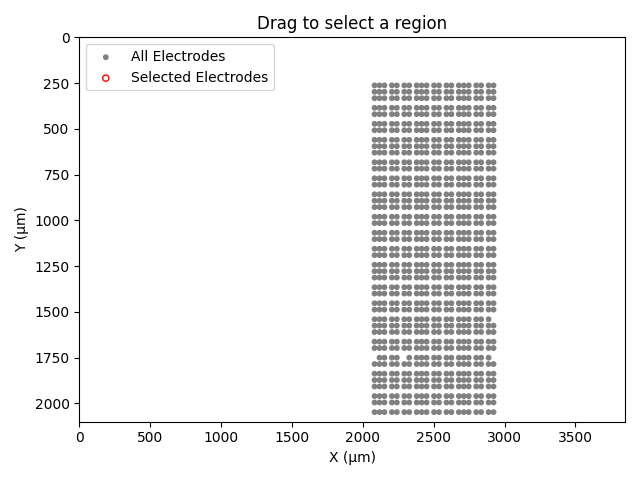

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

# Enable interactive matplotlib
%matplotlib widget

# Ensure required variables are defined
# Replace these with your actual data
locs = recording_chunk.get_channel_locations()  # 2D locations of electrodes
channel_ids = recording_chunk.get_channel_ids()  # Channel IDs
electrodes = np.array(electrodes)  # List of electrode IDs

# Widgets to enter electrode IDs to highlight
highlight_input = widgets.Text(
    description='Highlight:',
    placeholder='e.g. 10, 15, 23',
    layout=widgets.Layout(width='50%')
)

highlight_button = widgets.Button(
    description='Highlight Electrodes',
    button_style='info'
)

# Setup figure
fig, ax = plt.subplots()

# Initial colors: all gray
c = np.array(['gray'] * len(electrodes))

def update_highlight_colors(electrodes_to_highlight):
    global c
    c = np.array(['gray'] * len(electrodes))
    highlight_mask = np.isin(electrodes, electrodes_to_highlight)
    c[highlight_mask] = 'blue'
    sc.set_color(c)
    fig.canvas.draw_idle()

# Scatter plot of electrode locations
sc = ax.scatter(locs[:, 0], locs[:, 1], c=c, label='All Electrodes', s=10)
ax.set_title("Drag to select a region")
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)")

# Invert the y-axis to match typical electrode layouts
ax.invert_yaxis()

# Scatter plot for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Electrodes')
selected_electrodes = []

# Create an output widget for displaying messages
output = widgets.Output()

# Function to map electrodes to channel numbers
def map_electrodes_to_channels(electrode_list):
    channel_numbers = []
    for electrode in electrode_list:
        if electrode in electrodes:
            channel_index = electrodes.tolist().index(electrode)  # Find the index of the electrode
            channel_numbers.append(channel_ids[channel_index])  # Map to channel number
        else:
            print(f"Electrode {electrode} not found.")
    return list(map(int, channel_numbers))

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_electrodes
    if eclick.xdata is None or erelease.xdata is None:  # Ignore clicks outside the plot
        return

    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata

    # Mask to find electrodes within the selected region
    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = electrodes[mask]

    # Check if Ctrl key is pressed (use event modifiers)
    if eclick.key == 'control':  # Append to existing selection
        selected_electrodes = np.unique(np.concatenate((selected_electrodes, new_selection)))
    else:  # Overwrite selection
        selected_electrodes = new_selection

    # Update the scatter plot for selected electrodes
    selected_plot.set_offsets(locs[np.isin(electrodes, selected_electrodes)])
    fig.canvas.draw_idle()

    # Display the selection details in the output widget
    with output:
        output.clear_output()  # Clear previous messages
        print(f"🔴 Selected {len(selected_electrodes)} electrodes")
        print(selected_electrodes)
        mapped_channels = map_electrodes_to_channels(selected_electrodes)
        print("Mapped Channels:", mapped_channels)
# Create RectangleSelector
selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]  # Left mouse button
)

# Create save button
save_button = widgets.Button(
    description="💾 Save Selected Electrodes",
    button_style='success',
    tooltip='Save selected electrode IDs to file'
)

def on_highlight_button_click(b):
    with output:
        output.clear_output()
        try:
            input_text = highlight_input.value.strip()
            if input_text == "":
                print("No electrodes entered.")
                return
            electrodes_to_highlight = np.array([int(x.strip()) for x in input_text.split(',')])
            update_highlight_colors(electrodes_to_highlight)
            print(f"🔵 Highlighted electrodes: {electrodes_to_highlight}")
        except Exception as e:
            print(f"Error parsing input: {e}")

highlight_button.on_click(on_highlight_button_click)

# Define callback to save to file
def save_selected_electrodes_to_file(b):
    if len(selected_electrodes) == 0:
        with output:
            output.clear_output()
            print("No electrodes selected to save.")
        return

    save_path = "selected_electrodes.txt"
    with open(save_path, "w") as f:
        for el in selected_electrodes:
            f.write(f"{el}\n")

    with output:
        output.clear_output()
        print(f"Saved {len(selected_electrodes)} electrode IDs to {os.path.abspath(save_path)}")

# Attach callback and show button
save_button.on_click(save_selected_electrodes_to_file)

# Display all controls
display(widgets.VBox([
    widgets.HBox([highlight_input, highlight_button]),
    save_button,
    output
]))
plt.xlim([0,3850])
plt.ylim(2100,0)

plt.legend()
plt.tight_layout()
plt.show()

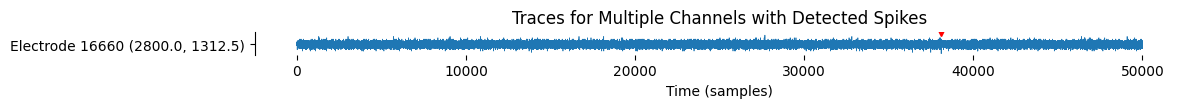

In [7]:
import os

import numpy as np
import matplotlib.pyplot as plt

plt.close('all')  # Close all existing figures to prevent multiple plots

# Define the detect_peaks_stddev function
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    """
    Detect peaks in a signal based on standard deviation thresholding.

    Parameters:
    - trace: 1D numpy array, the signal to analyze
    - peak_sign: str, "pos" for positive peaks, "neg" for negative peaks
    - std_multiplier: float, the threshold multiplier for peak detection

    Returns:
    - peaks: numpy array, indices of detected peaks
    - threshold: float, the threshold value used for detection
    """
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std

    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & (trace[1:-1] > trace[2:]) & (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & (trace[1:-1] < trace[2:]) & (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")

    return peaks, threshold
%matplotlib inline
# Ensure channels_to_plot only contains valid indices within the bounds of the traces array
channels_to_plot = [135]
fs = recording_chunk.get_sampling_frequency()
start_time = 40 # Start time in seconds
end_time = 45 # End time in seconds
# Get traces for the specified range
traces = recording_chunk.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0, return_scaled=True)

# Define the channels you want to plot
 # Replace with the desired channel indices
#channels_to_plot = range(traces.shape[1])  # Example channel indices
# Parameters for spike detection
peak_sign = "neg"  # Detect negative peaks
std_multiplier = 4 # Threshold: 1 standard deviation from the mean

# Adjust figure height dynamically based on the number of channels
plt.figure(figsize=(12, len(channels_to_plot) * 0.3))  # Increase height for better spacing

# Extract channel IDs and 2D location coordinates
channel_ids = np.array([int(x) for x in recording_chunk.get_channel_ids()])
locs = recording_chunk.get_channel_locations()  # Define locs here
# Ensure channels_to_plot only contains valid indices within the bounds of the traces array
channels_to_plot_indices = [np.where(channel_ids == ch)[0][0] for ch in channels_to_plot if ch in channel_ids]

# Loop through the channels and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store channel names for labeling

spike_times_channel = {} # Store spike times for each channel
for i, channel_idx in enumerate(channels_to_plot_indices):
    # Get the trace for the current channel
    trace = traces[:, channel_idx]
    
    # Detect peaks using the detect_peaks function
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)

    
    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks_sample_inds.astype(int)
    spike_times_channel[channel] = peaks_sample_inds  # Store spike times for the channel

    spike_marker_offset = 100
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        label=f'Electrode {electrodes[channel_idx]}',  # Use the actual channel ID for labeling
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Channel {electrodes[channel_idx]}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * 200)
    
    # Retrieve the x, y coordinates for the channel
    x, y = locs[channel_idx]  # Use the index to get the location
    yticks_labels.append(f'Electrode {electrodes[channel_idx]} ({x:.1f}, {y:.1f})')  # Format with coordinates

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels with Detected Spikes')

# Add y-axis ticks with channel names and coordinates
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_multiple_channels_with_spikes.pdf'  # Replace with your desired path
plt.show() 
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
plt.close()  # Close the plot to free memory

In [15]:
# for i, electrode_idx in enumerate(sorted_indices):
#     print(f"Electrode {electrode}: {distance:.2f} μm")
#     # Get the trace for the current electrode
#     trace = traces[:, electrode_idx]
#     std = np.std(trace)
#     rms = np.sqrt(np.mean(trace**2))
#
#     print(f"Std for electrode {electrodes[electrode_idx]}: {std:.2f}")
#     print(f"RMS for electrode {electrodes[electrode_idx]}: {rms:.2f}")
#     peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier= std_multiplier)
#
#     # Convert peaks_sample_inds to integers
#     peaks_sample_inds = peaks_sample_inds.astype(int)
#     spike_times_electrode[electrodes[electrode_idx]] = peaks_sample_inds  # Store spike times for the electrode
#     print(f'Electrode {electrodes[electrode_idx]} ({x:.1f}, {y:.1f})')  # Format with coordinates


In [35]:
for channel_id in recording_chunk.get_channel_ids(): 
    print(int(channel_id), ",")

0 ,
1 ,
2 ,
3 ,
4 ,
5 ,
6 ,
7 ,
8 ,
9 ,
10 ,
11 ,
12 ,
13 ,
14 ,
15 ,
16 ,
17 ,
18 ,
19 ,
20 ,
21 ,
22 ,
23 ,
25 ,
26 ,
27 ,
28 ,
29 ,
30 ,
31 ,
32 ,
33 ,
34 ,
35 ,
37 ,
38 ,
39 ,
40 ,
41 ,
42 ,
43 ,
44 ,
45 ,
46 ,
47 ,
48 ,
49 ,
50 ,
51 ,
53 ,
54 ,
55 ,
56 ,
57 ,
58 ,
59 ,
60 ,
61 ,
62 ,
63 ,
64 ,
65 ,
66 ,
67 ,
68 ,
69 ,
70 ,
71 ,
72 ,
73 ,
74 ,
75 ,
76 ,
77 ,
78 ,
79 ,
81 ,
82 ,
83 ,
84 ,
85 ,
86 ,
87 ,
88 ,
89 ,
90 ,
91 ,
93 ,
94 ,
95 ,
97 ,
98 ,
99 ,
100 ,
101 ,
102 ,
103 ,
105 ,
106 ,
107 ,
108 ,
109 ,
110 ,
111 ,
112 ,
113 ,
114 ,
115 ,
116 ,
117 ,
118 ,
119 ,
121 ,
122 ,
123 ,
125 ,
126 ,
127 ,
129 ,
130 ,
131 ,
133 ,
134 ,
135 ,
137 ,
138 ,
139 ,
141 ,
142 ,
143 ,
145 ,
146 ,
147 ,
149 ,
150 ,
151 ,
153 ,
154 ,
155 ,
157 ,
158 ,
159 ,
161 ,
162 ,
163 ,
165 ,
166 ,
167 ,
169 ,
170 ,
171 ,
173 ,
174 ,
175 ,
177 ,
178 ,
179 ,
181 ,
182 ,
183 ,
185 ,
186 ,
187 ,
189 ,
190 ,
191 ,
193 ,
194 ,
195 ,
197 ,
198 ,
199 ,
201 ,
202 ,
203 ,
205 ,
206 ,
207 ,
209 ,
210 ,
211 ,
213 ,
214 ,


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')  # Close old figures

# Define the detect_peaks_stddev function
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std

    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & 
                         (trace[1:-1] > trace[2:]) & 
                         (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & 
                         (trace[1:-1] < trace[2:]) & 
                         (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")
    return peaks, threshold

%matplotlib inline

# Choose channels to plot (make sure they exist in the recording)
channels_to_plot = [135]

# Get full recording traces (to keep time consistent with DataFrame code)
fs = recording_chunk.get_sampling_frequency()
traces = recording_chunk.get_traces(segment_index=0, return_scaled=True)

# Extract channel IDs and locations
channel_ids = np.array([int(x) for x in recording_chunk.get_channel_ids()])
locs = recording_chunk.get_channel_locations()

channels_to_plot_indices = [np.where(channel_ids == ch)[0][0] for ch in channels_to_plot if ch in channel_ids]

# Figure setup
plt.figure(figsize=(12, len(channels_to_plot) * 0.3))

yticks_positions = []
yticks_labels = []
spike_times_channel = {}

for i, channel_idx in enumerate(channels_to_plot_indices):
    trace = traces[:, channel_idx]

    # Detect both positive + negative spikes with std=4 (to match other code)
    neg_inds, _ = detect_peaks_stddev(trace, "neg", 4)
    pos_inds, _ = detect_peaks_stddev(trace, "pos", 4)
    peaks_sample_inds = np.sort(np.concatenate([neg_inds, pos_inds]))

    # Store spike times in samples
    spike_times_channel[channel_ids[channel_idx]] = peaks_sample_inds

    # Plot traces
    plt.plot(
        trace + i * 200,
        label=f'Electrode {channel_ids[channel_idx]}',
        rasterized=True,
        linewidth=0.5
    )

    # Mark spikes with red triangles
    spike_marker_offset = 100
    plt.plot(
        peaks_sample_inds,
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,
        'rv',
        markersize=4
    )

    # Add y-axis ticks
    yticks_positions.append(i * 200)
    x, y = locs[channel_idx]
    yticks_labels.append(f'Electrode {channel_ids[channel_idx]} ({x:.1f}, {y:.1f})')

# Customize plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels with Detected Spikes')
plt.yticks(yticks_positions, yticks_labels)

# Save + show
output_path = './savetraces_multiple_channels_with_spikes.pdf'
plt.show()
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)
plt.close()


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Example DataFrame
# df = pd.read_csv("your_data.csv")

# Suppose your site IDs are in a column called 'site'

# Dictionary mapping each site to its row indices (0-indexed)

# Print
for site, rows in channdel_ids.items():
    print(f"Site {site}: rows {rows}")


NameError: name 'df' is not defined

In [69]:

# Define the reference point
reference_point = (0, 0)

# Retrieve the 2D locations of the electrodes
locs = recording_chunk.get_channel_locations()

# Calculate distances for each electrode
distances = np.sqrt((locs[:, 0] - reference_point[0])**2 + (locs[:, 1] - reference_point[1])**2)

# Sort electrodes by distance (ascending order)
sorted_indices = np.argsort(distances)
sorted_electrodes = [electrodes[idx] for idx in sorted_indices]
sorted_distances = distances[sorted_indices]



In [ ]:
for channel_id in channel_ids: 
    print(x) 
    

NameError: name 'x' is not defined

In [ ]:
results = []
traces = recording_chunk.get_traces(segment_index=0, return_scaled=True)

for i, electrode_idx in enumerate(sorted_indices):
    # Get electrode ID
    electrode_id = electrodes[electrode_idx]

    # Trace + stats
    trace = traces[:, electrode_idx]
    std = np.std(trace)
    rms = np.sqrt(np.mean(trace**2))

    # Peak detection
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier=5)
    peaks_sample_inds = peaks_sample_inds.astype(int)

    # Coordinates (make sure x, y are set per electrode!)
    results.append({
        "Electrode": electrode_id,
        "Distance (μm)": distances,
        "Std": std,
        "RMS": rms,
        "Spike Count": len(peaks_sample_inds),
        "Spike Times": peaks_sample_inds.tolist(),
        "X": x,
        "Y": y
    })

# Convert to DataFrame
df_electrode_rms_stats = pd.DataFrame(results)

df_electrode_rms_stats.sort_values(by="Spike Count", ascending = False, inplace=True)
df_electrode_rms_stats


KeyboardInterrupt: 

In [13]:
batch_size = recording_chunk.get_num_frames(segment_index=0) // num_seg
print(f"Batch size: {batch_size}")


Batch size: 1000000


In [9]:
# Example: Get number of peaks for a specific electrode
electrode_index = 707  # Replace with the index of your electrode
trace = traces[:, electrode_index]  # Extract the trace for the electrode

# Detect peaks
peaks, threshold = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier=4)

# Total number of peaks for this electrode
num_peaks = len(peaks)
print(f"Total number of peaks for electrode {electrodes[electrode_index]}: {num_peaks}")

Total number of peaks for electrode 13541: 155


In [10]:
# Collect Std and RMS for all electrodes
std_rms_per_electrode = {}
for electrode_index in range(traces.shape[1]):
    trace = traces[:, electrode_index]
    std = np.std(trace)
    rms = np.sqrt(np.mean(trace**2))
    std_rms_per_electrode[electrodes[electrode_index]] = {"Std": std, "RMS": rms}
    print(f"Electrode {electrodes[electrode_index]}: Std = {std:.2f}, RMS = {rms:.2f}")

# Optionally, display as a DataFrame
import pandas as pd
std_rms_df = pd.DataFrame.from_dict(std_rms_per_electrode, orient='index')
display(std_rms_df)

Electrode 12910: Std = 8.44, RMS = 8.44
Electrode 16217: Std = 9.30, RMS = 9.30
Electrode 10258: Std = 7.88, RMS = 7.88
Electrode 20402: Std = 8.77, RMS = 8.77
Electrode 13543: Std = 8.01, RMS = 8.01
Electrode 16213: Std = 8.57, RMS = 8.57
Electrode 13981: Std = 8.37, RMS = 8.37
Electrode 9847: Std = 7.59, RMS = 7.59
Electrode 15777: Std = 8.82, RMS = 8.82
Electrode 11380: Std = 7.15, RMS = 7.15
Electrode 15086: Std = 8.16, RMS = 8.16
Electrode 14675: Std = 9.04, RMS = 9.04
Electrode 16203: Std = 8.54, RMS = 8.54
Electrode 11356: Std = 8.27, RMS = 8.27
Electrode 5411: Std = 6.57, RMS = 6.57
Electrode 15117: Std = 7.78, RMS = 7.78
Electrode 12886: Std = 9.52, RMS = 9.52
Electrode 14651: Std = 9.32, RMS = 9.32
Electrode 15739: Std = 8.59, RMS = 8.59
Electrode 17320: Std = 8.78, RMS = 8.78
Electrode 13565: Std = 11.90, RMS = 11.90
Electrode 14010: Std = 8.93, RMS = 8.93
Electrode 11793: Std = 8.24, RMS = 8.24
Electrode 15113: Std = 8.09, RMS = 8.09
Electrode 13580: Std = 8.15, RMS = 8.15


,Std,RMS
12910,8.440778,8.440777
16217,9.303477,9.303476
10258,7.879832,7.879833
20402,8.773611,8.773611
13543,8.006549,8.006549
...,...,...
24771,8.460937,8.460936
7180,8.635506,8.635507
4311,7.832528,7.832530
15760,8.461528,8.461528


In [21]:
# For each electrode, if std > 6, count as 1 peak, and record amplitude and time of the largest peak
peak_summary = []
fs = recording_chunk.get_sampling_frequency()  # Ensure fs is defined
for electrode_index in range(traces.shape[1]):
    trace = traces[:, electrode_index]
    std = np.std(trace)
    rms = np.sqrt(np.mean(trace**2))
    if rms > 6:
        # Find the largest peak (amplitude and time)
        peak_idx = np.argmax(np.abs(trace))
        amplitude = trace[peak_idx]
        time_point = peak_idx / fs
        peak_summary.append({
            "Electrode": electrodes[electrode_index],
            "Std": std,
            "RMS": rms,
            "Peak_Amplitude": amplitude,
            "Peak_Time_s": time_point
        })
        print(f"Electrode {electrodes[electrode_index]}: Std = {std:.2f}, RMS = {rms:.2f}, Peak Amplitude = {amplitude:.2f}, Time = {time_point:.3f} s")
    else:
        peak_summary.append({
            "Electrode": electrodes[electrode_index],
            "Std": std,
            "RMS": rms,
            "Peak_Amplitude": None,
            "Peak_Time_s": None
        })

# Display as DataFrame
import pandas as pd
peak_summary_df = pd.DataFrame(peak_summary)
display(peak_summary_df)


Electrode 9118: Std = 8.51, RMS = 8.51, Peak Amplitude = 44.06, Time = 4.544 s
Electrode 15730: Std = 8.11, RMS = 8.11, Peak Amplitude = -37.77, Time = 4.275 s
Electrode 12455: Std = 8.05, RMS = 8.05, Peak Amplitude = 37.77, Time = 10.984 s
Electrode 13520: Std = 7.77, RMS = 7.77, Peak Amplitude = 37.77, Time = 6.361 s
Electrode 11790: Std = 6.06, RMS = 6.06, Peak Amplitude = 25.18, Time = 0.360 s
Electrode 14618: Std = 7.81, RMS = 7.81, Peak Amplitude = 37.77, Time = 4.401 s
Electrode 11810: Std = 6.49, RMS = 6.49, Peak Amplitude = 31.47, Time = 0.516 s
Electrode 15097: Std = 8.07, RMS = 8.07, Peak Amplitude = 37.77, Time = 1.568 s
Electrode 13962: Std = 8.36, RMS = 8.36, Peak Amplitude = 37.77, Time = 0.317 s
Electrode 17292: Std = 7.93, RMS = 7.93, Peak Amplitude = -37.77, Time = 0.405 s
Electrode 11335: Std = 7.31, RMS = 7.31, Peak Amplitude = 31.47, Time = 1.652 s
Electrode 14655: Std = 8.57, RMS = 8.57, Peak Amplitude = 44.06, Time = 12.784 s
Electrode 16165: Std = 6.92, RMS = 6.

,Electrode,Std,RMS,Peak_Amplitude,Peak_Time_s
0,9118,8.509425,8.509425,44.059753,4.5443
1,15730,8.114381,8.114383,-37.765503,4.2747
2,12455,8.049699,8.049700,37.765503,10.9837
3,13520,7.769158,7.769163,37.765503,6.3611
4,11790,6.064604,6.064606,25.177002,0.3604
...,...,...,...,...,...
768,24990,6.183654,6.183654,31.471252,34.2526
769,6262,6.448540,6.448541,31.471252,10.5764
770,9587,7.404608,7.404609,-37.765503,47.8093
771,21658,7.873052,7.873052,37.765503,7.7799


In [ ]:
peak_summary_df.sort_values(by="RMS", ascending=False)

In [ ]:
# import numpy as np

# import matplotlib.pyplot as plt

# # Electrode and spike info
# electrode_id = 13575
# fs = recording_chunk.get_sampling_frequency()  # Hz

# # Get channel index for electrode 17743
# if electrode_id in electrodes:
#     ch_idx = np.where(np.array(electrodes) == electrode_id)[0][0]
# else:
#     raise ValueError(f"Electrode {electrode_id} not found.")

# # Get spike times for this electrode (in samples)
# spike_inds = spike_times_electrode.get(electrode_id, [])
# if len(spike_inds) == 0:
#     print(f"No spikes detected for electrode {electrode_id}.")
# else:
#     # Show all spikes for this electrode
#     for peak_idx in spike_inds:
#         # Define window: ±2 ms around the spike
#         window_ms = 2
#         window_samples = int(window_ms * fs / 1000)
#         start = max(0, peak_idx - window_samples)
#         end = min(traces.shape[0], peak_idx + window_samples + 1)
#         trace_window = traces[start:end, ch_idx]
#         time_axis = (np.arange(start, end) - peak_idx) / fs * 1000  # ms, centered at spike

#         # plt.figure(figsize=(6, 3))
#         # plt.plot(time_axis, trace_window, label=f'Electrode {electrode_id}')
#         # plt.axvline(0, color='red', linestyle='--', label='Detected Peak')
#         # plt.xlabel('Time (ms)')
#         # plt.ylabel('Amplitude (µV)')
#         # plt.title(f'Peak at Electrode {electrode_id} (Sample {peak_idx})')
#         # plt.legend()
#         # plt.tight_layout()
#         # plt.show()

In [11]:
# Example: Convert spike sample indices to milliseconds for all electrodes
fs = recording_chunk.get_sampling_frequency()  # Sampling frequency in Hz

# Assuming you have a DataFrame like df_electrode_rms_stats with a "Spike Times" column
df_electrode_rms_stats["Spike Times (ms)"] = df_electrode_rms_stats["Spike Times"].apply(
    lambda inds: [((i / 10000)) for i in inds]
)

# Sort the DataFrame by "Spike Count" in descending order and display
df_electrode_rms_stats_sorted = df_electrode_rms_stats.sort_values(by="Spike Count", ascending=False)
# Remove rows with 0 spike count
df_electrode_rms_stats_sorted = df_electrode_rms_stats_sorted[df_electrode_rms_stats_sorted["Spike Count"] > 0]
df_electrode_rms_stats_sorted[["Electrode", "Spike Count", "Spike Times (ms)"]]

,Electrode,Spike Count,Spike Times (ms)
702,24116,226,"[0.1156, 0.3682, 0.4369, 0.8258, 1.3835, 2.300..."
638,14677,18,"[1.1816, 11.1921, 18.0473, 19.6228, 25.1765, 2..."
636,24768,15,"[4.0684, 5.951, 6.4594, 6.6045, 6.6193, 12.170..."
138,9153,15,"[0.8771, 1.0001, 2.5912, 4.2759, 20.8659, 35.3..."
730,23680,14,"[4.3198, 27.629, 35.9449, 57.3618, 59.8717, 60..."
...,...,...,...
410,12468,1,[19.2062]
620,15115,1,[27.9692]
514,18840,1,[73.094]
370,3895,1,[99.0745]


In [ ]:
# import numpy as np

# import matplotlib.pyplot as plt

# # Get electrode locations as numpy array
# locs = np.array(recording_chunk.get_channel_locations())
# electrodes_arr = np.array(electrodes)

# # Find electrodes with > 0 spike count
# spike_count = np.array([len(spike_times_electrode.get(e, [])) for e in electrodes_arr])
# has_spikes = spike_count > 0

# # Plot all electrodes in gray
# plt.figure(figsize=(8, 5))
# plt.scatter(locs[:, 0], locs[:, 1], c='lightgray', s=30, label='All electrodes')

# # Highlight electrodes with > 0 spikes in blue
# plt.scatter(locs[has_spikes, 0], locs[has_spikes, 1], c='blue', s=40, label='>0 spikes')
# plt.xlim([0, 3800])
# plt.ylim([0, 2100])
# plt.xlabel('X (μm)')
# plt.ylabel('Y (μm)')
# plt.title('Electrodes with > 0 Spikes Highlighted')
# plt.legend()
# plt.gca().invert_yaxis()
# plt.tight_layout()

In [22]:
# Find index in sorted_electrodes
idx_in_sorted_electrodes = sorted_electrodes.index(11822)
print(idx_in_sorted_electrodes)

ValueError: 11822 is not in list

In [10]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
%matplotlib widget

# Visualize the traces interactively
print("Visualizing traces interactively...")
sw.plot_traces(recording_chunk, mode='line',show_channel_ids=[661, 720, 748, 752, 909, 976], backend='ipywidgets')  # Updated function name

# Create a text box for user input
electrode_input = widgets.Text(
    description="Electrode:",
    placeholder="Enter electrode number",
)

# Create an output widget to display the result
output = widgets.Output()

# Define a function to handle the input and display the corresponding channel indices
def find_channel_indices(change):
    with output:
        output.clear_output()  # Clear previous output
        try:
            # Get the input value and split it into a list of electrode numbers
            electrode_numbers = [int(e.strip()) for e in change["new"].split(",")]
            channel_indices = []
            for electrode_number in electrode_numbers:
                if electrode_number in electrodes:
                    channel_index = electrodes.index(electrode_number)  # Find the index
                    channel_indices.append(channel_index)
                else:
                    print(f"Electrode {electrode_number} not found.")
            if channel_indices:
                print(f"Electrode numbers {electrode_numbers} correspond to Channel Indices {channel_indices}")
        except ValueError:
            print("Please enter valid integers separated by commas.")

# Attach the function to the text box
electrode_input.observe(find_channel_indices, names="value")

# Display the widgets
display(widgets.VBox([electrode_input, output]))



Visualizing traces interactively...


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [11]:
# Function to map electrodes to channel numbers
def map_electrodes_to_channels(electrode_list):
    channel_numbers = []
    for electrode in electrode_list:
        if electrode in electrodes:
            # electrodes is a numpy array, so use np.where to find the index
            channel_index = np.where(electrodes == electrode)[0][0]
            channel_numbers.append(channel_ids[channel_index])  # Map to channel number
        else:
            print(f"Electrode {electrode} not found.")
    return channel_numbers

# Example usage
user_electrode_list = [16660, 16662, 16222, 16220]
mapped_channels = map_electrodes_to_channels(user_electrode_list)
print("Mapped Channels:", mapped_channels)

Mapped Channels: [135, 219, 495, 235]


In [12]:
# Function to map channel numbers to electrode numbers
def map_channels_to_electrodes(channel_list):
    electrode_numbers = []
    for channel in channel_list:
        if channel in channel_ids.astype(int):
            channel_index = np.where(channel_ids.astype(int) == channel)[0][0]  # Find the index of the channel
            electrode_numbers.append(electrodes[channel_index])  # Map to electrode number
        else:
            print(f"Channel {channel} not found.")
    return electrode_numbers

# Example usage
input_channels = [843]  # Replace with your desired channel numbers
mapped_electrodes = map_channels_to_electrodes(input_channels)
print("Mapped Electrodes:", mapped_electrodes)

Mapped Electrodes: [17743]


In [ ]:
peak_summary_df = peak_summary_df.sort_values(by="Peak_Amplitude", ascending=False)
peak_summary_df

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

from matplotlib.image import imread

# Enable interactive matplotlib
%matplotlib widget

# Load the background image
img_path = "/home/shruti/Downloads/MEASlices/M07896 MEA Slices FullScan25s after spicy(1).png"
img = imread(img_path)

# Get electrode locations
locs = recording_chunk.get_channel_locations()
channel_ids = recording_chunk.get_channel_ids()
electrodes = np.array(electrodes)

# Determine extent for the image (fit to locs)
# Define full plot extent to cover entire brain slice (adjust to your known coordinates)
x_min, x_max = 0, 3800
y_min, y_max = 0, 2100


# Calculate aspect ratio of the image
img_height, img_width = img.shape[:2]
aspect_ratio = img_width / img_height

# Set figure size with correct aspect ratio (tune fig_width as desired)
fig_width = 8  # inches
fig_height = fig_width / aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Show image with extent matching electrode locations and invert y for coordinate match
# Show background image spanning entire coordinate range
ax.imshow(img, extent=[x_min, x_max, y_max, y_min], aspect='auto', alpha=0.7)
# After displaying image, plot electrodes
electrode_marker_size = 30  # increase size for visibility
electrode_edge_color = 'black'
# Electrode scatter plot remains unchanged (already in correct coordinates)
sc = ax.scatter(
    locs[:, 0], locs[:, 1],
    c='grey',
    s=25,
    edgecolors='black',
    linewidth=0.8
)

# Set axis limits tightly to image extents to fill whole graph
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_max, y_min)  # y inverted

# Invert y-axis explicitly for MEA layout matching
#ax.invert_yaxis()


# Scatter plot for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Electrodes')
selected_electrodes = []

# Widgets to enter electrode IDs to highlight
highlight_input = widgets.Text(
    description='Highlight:',
    placeholder='e.g. 10, 15, 23',
    layout=widgets.Layout(width='50%')
)
highlight_button = widgets.Button(
    description='Highlight Electrodes',
    button_style='info'
)
output = widgets.Output()

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_electrodes
    if eclick.xdata is None or erelease.xdata is None:
        return
    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata
    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = electrodes[mask]
    if eclick.key == 'control':
        selected_electrodes = np.unique(np.concatenate((selected_electrodes, new_selection)))
    else:
        selected_electrodes = new_selection
    selected_plot.set_offsets(locs[np.isin(electrodes, selected_electrodes)])
    fig.canvas.draw_idle()
    with output:
        output.clear_output()
        print(f"🔴 Selected {len(selected_electrodes)} electrodes")
        print(selected_electrodes)

selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]
)

save_button = widgets.Button(
    description="💾 Save Selected Electrodes",
    button_style='success',
    tooltip='Save selected electrode IDs to file'
)

def on_highlight_button_click(b):
    with output:
        output.clear_output()
        try:
            input_text = highlight_input.value.strip()
            if input_text == "":
                print("No electrodes entered.")
                return
            electrodes_to_highlight = np.array([int(x.strip()) for x in input_text.split(',')])
            update_highlight_colors(electrodes_to_highlight)
            print(f"🔵 Highlighted electrodes: {electrodes_to_highlight}")
        except Exception as e:
            print(f"Error parsing input: {e}")

highlight_button.on_click(on_highlight_button_click)

def save_selected_electrodes_to_file(b):
    if len(selected_electrodes) == 0:
        with output:
            output.clear_output()
            print("No electrodes selected to save.")
        return
    save_path = "selected_electrodes.txt"
    with open(save_path, "w") as f:
        for el in selected_electrodes:
            f.write(f"{el}\n")
    with output:
        output.clear_output()
        print(f"Saved {len(selected_electrodes)} electrode IDs to {os.path.abspath(save_path)}")

save_button.on_click(save_selected_electrodes_to_file)
display(widgets.VBox([
    widgets.HBox([highlight_input, highlight_button]),
    save_button,
    output
]))
# Instead of plotting electrodes in grey, use RMS values from df_electrode_rms_stats
electrode_marker_size = 20
electrode_edge_color = 'black'

# Align RMS values to the electrode order
# Assuming locs[:,0], locs[:,1] correspond to the same electrodes in df_electrode_rms_stats
# If order mismatch, merge on 'Electrode' instead
x_coords = df_electrode_rms_stats["X"].values
y_coords = df_electrode_rms_stats["Y"].values
rms_values = df_electrode_rms_stats["RMS"].values

# Calculate 25th and 75th percentiles
vmin = np.percentile(rms_values, 15)
vmax = np.percentile(rms_values, 85)

# Scatter with RMS as colormap, using vmin and vmax to cut off extremes
sc = ax.scatter(
    locs[:, 0], locs[:, 1],
    c=rms_values,
    cmap="jet",
    s=electrode_marker_size,
    edgecolors=electrode_edge_color,
    linewidth=0.8,
    vmin=vmin,
    vmax=vmax
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("RMS Value of Signal (µV)")

# Axis labels and title
ax.set_xlabel("X Coordinate (µm)")
ax.set_ylabel("Y Coordinate (µm)")
ax.set_title("Heatmap of RMS Activity on Brain Slice")

plt.show()

plt.legend()
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/shruti/Downloads/MEASlices/M07896 MEA Slices FullScan25s after spicy(1).png'

In [13]:
# Instead of plotting electrodes in grey, use RMS values from df_electrode_rms_stats
electrode_marker_size = 20
electrode_edge_color = 'black'

# Align RMS values to the electrode order
# Assuming locs[:,0], locs[:,1] correspond to the same electrodes in df_electrode_rms_stats
# If order mismatch, merge on 'Electrode' instead
x_coords = df_electrode_rms_stats["X"].values
y_coords = df_electrode_rms_stats["Y"].values
rms_values = df_electrode_rms_stats["RMS"].values

# Calculate 25th and 75th percentiles
vmin = np.percentile(rms_values, 15)
vmax = np.percentile(rms_values, 85)

# Scatter with RMS as colormap, using vmin and vmax to cut off extremes
sc = ax.scatter(
    locs[:, 0], locs[:, 1],
    c=rms_values,
    cmap="jet",
    s=electrode_marker_size,
    edgecolors=electrode_edge_color,
    linewidth=0.8,
    vmin=vmin,
    vmax=vmax
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("RMS Value of Signal (µV)")

# Axis labels and title
ax.set_xlabel("X Coordinate (µm)")
ax.set_ylabel("Y Coordinate (µm)")
ax.set_title("Heatmap of RMS Activity on Brain Slice")

plt.show()

NameError: name 'df_electrode_rms_stats' is not defined

In [28]:
# Check if electrode 3453 is in the DataFrame index
if 3453 in df_electrode_rms_stats.index:
    print(df_electrode_rms_stats.loc[3453])
else:
    print("Electrode 3453 not found in df_electrode_rms_stats.")

Electrode 3453 not found in df_electrode_rms_stats.


In [29]:
print(f"Total trace duration: {total_time_sec:.2f} seconds")
print(f"Number of samples: {traces.shape[0]}")
print(f"Sampling frequency: {fs} Hz")

NameError: name 'total_time_sec' is not defined

In [ ]:
# Sort electrodes based on distance from reference point (0, 0)
# import numpy as np
# import matplotlib.pyplot as plt

# Define the reference point
# reference_point = (0, 0)

# Retrieve the 2D locations of the electrodes
# locs = recording_chunk.get_channel_locations()

# Calculate distances for each electrode
# distances = np.sqrt((locs[:, 0] - reference_point[0])**2 + (locs[:, 1] - reference_point[1])**2)

# Sort electrodes by distance (ascending order)
# sorted_indices = np.argsort(distances)
# sorted_electrodes = [electrodes[idx] for idx in sorted_indices]
# sorted_distances = distances[sorted_indices]


# for electrode, distance in zip(sorted_electrodes, sorted_distances):
#     print(f"Electrode {electrode}: {distance:.2f} μm")

# Update the order of electrodes to plot based on sorted electrodes
# electrodes_to_plot_sorted = [electrode for electrode in sorted_electrodes if electrode in electrodes_to_plot]


# Validate that electrodes_to_plot_sorted is not empty
# if not electrodes_to_plot_sorted:
#     raise ValueError("The `electrodes_to_plot_sorted` list is empty. Ensure `electrodes_to_plot` and `electrodes` are correctly defined.")

# Plot the sorted electrodes
# yticks_positions = []  # Store y-axis positions for labeling
# yticks_labels = []  # Store electrode names for labeling

# plt.figure(figsize=(12, len(electrodes_to_plot_sorted) * 0.3))  # Adjust figure height dynamically

# spike_marker_offset = 100  # Define spike marker offset

# for i, electrode in enumerate(electrodes_to_plot_sorted):
#     electrode_idx_array = np.where(np.array(electrodes) == electrode)[0]
#     if electrode_idx_array.size == 0:
#         print(f"Warning: Electrode {electrode} not found in electrodes.")
#         continue  # Skip this electrode if it is not found
#     trace = traces[:, electrode_idx_array[0]]
#     peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)

#     # Check if spikes are detected
#     if len(peaks_sample_inds) == 0:
#         print(f"Warning: No spikes detected for electrode {electrode}.")

#     # Plot the trace with increased spacing
#     plt.plot(
#         trace + i * 200,  # Increase the offset to 200 for better spacing
#         rasterized=True,  # Rasterize the line plots for faster rendering
#         linewidth=0.5  # Use thinner lines for better performance
#     )

#     # Mark the detected spikes with red triangles
#     plt.plot(
#         peaks_sample_inds, 
#         trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
#         'rv',  # Red triangles
#         markersize=4, 
#         label=f'Spikes Electrode {electrodes[electrode_idx]}'
#     )
#     yticks_positions.append(i * 200)
#     yticks_labels.append(f'Electrode {sorted_electrodes[i]} ({sorted_distances[i]:.2f} μm)')

     

# Customize the plot
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.xlabel('Time (samples)')
# plt.title('Traces for Multiple Channels Sorted by Distance')
# plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
# output_path = './sorted_traces_by_distance.pdf'
# plt.show()
# plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)
# plt.close()


In [ ]:
print(df_electrode_rms_stats.sort_values(by="RMS", ascending=False))

In [ ]:
'''BREAK UNTIL GOOD CODE'''

In [30]:
mean = np.mean(trace)
std_values = []
for e in electrodes:
    std_ch = np.std(trace)
    std_values.append(std_ch)
print(std_values)
print(mean)

[6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384, 6.0683384

In [31]:
locations = recording_chunk.get_channel_locations()
print(locations.shape)
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids.shape)

(773, 2)
(773,)


In [ ]:
# --- Fix DataFrame: Ensure spike counts and spike times are accurate, and add firing rate ---
import numpy as np
import pandas as pd

# Ensure spike_times_electrode is a dict mapping electrode_id to spike indices (samples)
# Ensure electrodes is a list/array of all electrode IDs
# Ensure traces and fs are defined

# Build a new DataFrame with accurate spike counts and firing rates
rows = []
total_time_sec = traces.shape[0] / fs  # Total recording time in seconds
for idx, electrode_id in enumerate(electrodes):
    ch_idx = idx
    trace = traces[:, ch_idx]
    std = np.std(trace)
    rms = np.sqrt(np.mean(trace**2))
    # Get the trace for the electrode
    trace = traces[:, ch_idx]  # ch_idx is the channel index for the electrode

    # Detect spikes (peaks) using your function
    # Match earlier settings: detect both neg + pos peaks, std=4
    neg_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier=4)
    pos_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="pos", std_multiplier=4)
    spike_inds = np.sort(np.concatenate([neg_spike_inds, pos_spike_inds]))
  
    spike_count = len(spike_inds)
    firing_rate = spike_count / total_time_sec if total_time_sec > 0 else np.nan
    if spike_count > 0:
        # Find largest peak (by amplitude)
        peak_amplitudes = trace[spike_inds]
        max_idx = np.argmax(np.abs(peak_amplitudes))
        peak_amp = peak_amplitudes[max_idx]
        peak_time = spike_inds[max_idx] / fs
    else:
        peak_amp = np.nan
        peak_time = np.nan
    rows.append({
        'Electrode': electrode_id,
        'Std': std,
        'RMS': rms,
        'Spike Count': spike_count,
        'Firing Rate (Hz)': firing_rate,
        'Peak_Amplitude': peak_amp,
        'Peak_Time_s': peak_time
    })
fixed_df = pd.DataFrame(rows)
fixed_df = fixed_df.sort_values(by='Firing Rate (Hz)', ascending=False)
# Exclude channels with 0 spike count
fixed_df
# Show the fixed DataFrame

# User-defined list of electrodes to extract
user_electrodes = [16662, 16660, 16220, 16222]

# Filter the DataFrame to only show these electrodes
filtered_df = fixed_df[fixed_df['Electrode'].isin(user_electrodes)]

filtered_df

In [ ]:
print(f"Total trace duration: {total_time_sec:.2f} seconds")
print(f"Number of samples: {traces.shape[0]}")
print(f"Sampling frequency: {fs} Hz")

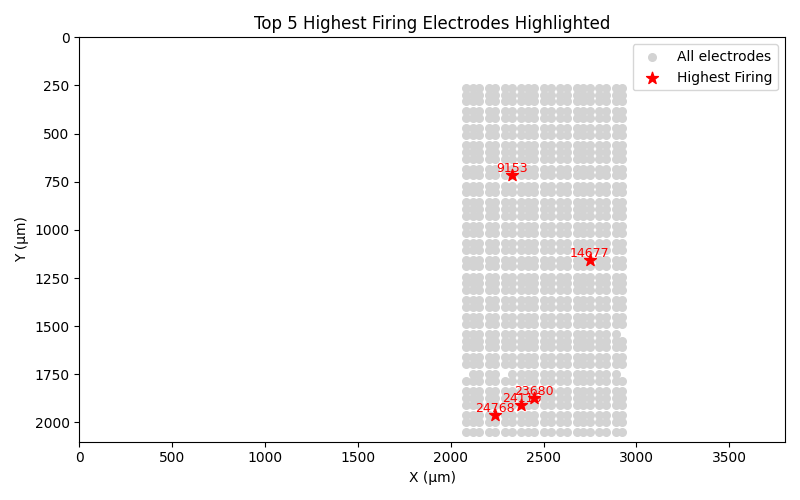

Top electrodes by spike count: [24116 14677 24768  9153 23680]


In [14]:
import numpy as np

import matplotlib.pyplot as plt

# Get electrode locations as numpy array
locs = np.array(recording_chunk.get_channel_locations())
electrodes_arr = np.array(electrodes)

# Find the electrodes with the highest firing rates (spike counts)
# Use fixed_df if available, otherwise use df_electrode_rms_stats
if 'fixed_df' in locals():
    df = fixed_df
    firing_col = 'Spike Count'
else:
    df = df_electrode_rms_stats
    firing_col = 'Spike Count' if 'Spike Count' in df.columns else None

# Get top N electrodes by spike count
N = 5
if firing_col:
    top_electrodes = df.sort_values(by=firing_col, ascending=False).head(N)['Electrode'].values
else:
    # Fallback: use spike_times_electrode dict
    spike_counts = {e: len(spike_times_electrode.get(e, [])) for e in electrodes_arr}
    top_electrodes = sorted(spike_counts, key=spike_counts.get, reverse=True)[:N]

# Find indices of top electrodes in the electrodes array
top_indices = [np.where(electrodes_arr == e)[0][0] for e in top_electrodes if e in electrodes_arr]

plt.figure(figsize=(8, 5))
plt.scatter(locs[:, 0], locs[:, 1], c='lightgray', s=30, label='All electrodes')
plt.scatter(locs[top_indices, 0], locs[top_indices, 1], c='red', s=80, marker='*', label='Highest Firing')

for idx in top_indices:
    plt.text(locs[idx, 0], locs[idx, 1], str(electrodes_arr[idx]), color='red', fontsize=9, ha='center', va='bottom')

plt.xlim([0, 3800])
plt.ylim([0, 2100])
plt.xlabel('X (μm)')
plt.ylabel('Y (μm)')
plt.title(f'Top {N} Highest Firing Electrodes Highlighted')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top electrodes by spike count:", top_electrodes)

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Electrode and spike info
# Set electrode_id to the one you want to plot
# Example: electrode_id = 13575
fs = recording_chunk.get_sampling_frequency()  # Hz

electrode_id = 14005  # Change as needed
if electrode_id in electrodes:
    ch_idx = np.where(np.array(electrodes) == electrode_id)[0][0]
else:
    raise ValueError(f"Electrode {electrode_id} not found.")

spike_inds = spike_times_electrode.get(electrode_id, [])
if len(spike_inds) == 0:
    print(f"No spikes detected for electrode {electrode_id}.")
else:
    for peak_idx in spike_inds:
        window_ms = 10
        window_samples = int(window_ms * fs / 1000)
        start = max(0, peak_idx - window_samples)
        end = min(traces.shape[0], peak_idx + window_samples + 1)
        trace_window = traces[start:end, ch_idx]
        # Actual time in ms for each sample in window
        time_axis = (np.arange(start, end) / fs)   # ms, absolute time in recording
        peak_time_ms = peak_idx / fs  # ms
        # Shift axis so peak is at its true time
        plt.figure(figsize=(6, 3))
        plt.plot(time_axis, trace_window, label=f'Electrode {electrode_id}')
        plt.axvline(peak_time_ms, color='red', linestyle='--', label='Detected Peak')
        plt.xlabel('Time (S, absolute in recording)')
        plt.ylabel('Amplitude (µV)')
        plt.title(f'Peak at Electrode {electrode_id} (Sample {peak_idx}, Time {peak_time_ms:.2f} ms)')
        plt.legend()
        plt.tight_layout()
        plt.show()

NameError: name 'spike_times_electrode' is not defined

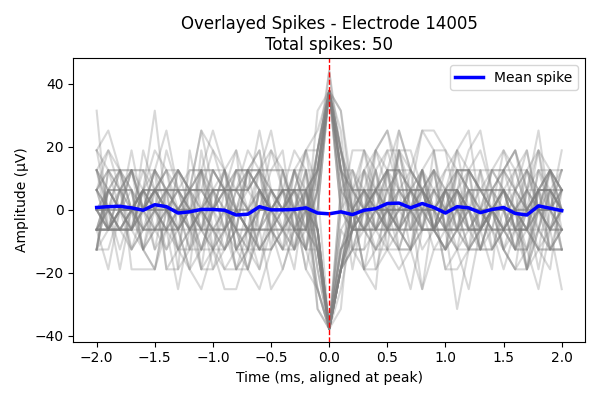

Recording length: 100.00 seconds (1.67 minutes)
Total spikes detected: 50
Spike rate: 0.50 Hz


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Electrode and spike info
fs = recording_chunk.get_sampling_frequency()  # Hz

electrode_id = 14005   # Change as needed
if electrode_id in electrodes:
    ch_idx = np.where(np.array(electrodes) == electrode_id)[0][0]
else:
    raise ValueError(f"Electrode {electrode_id} not found.")

trace = traces[:, ch_idx]

# Detect negative peaks
neg_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier=4)
# Detect positive peaks
pos_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="pos", std_multiplier=4)

all_spike_inds = np.sort(np.concatenate([neg_spike_inds, pos_spike_inds]))

if len(all_spike_inds) == 0:
    print(f"No spikes detected for electrode {electrode_id}.")
else:
    # Parameters
    window_ms =  2  # total window half-width
    window_samples = int(window_ms * fs / 1000)
    t_axis = np.arange(-window_samples, window_samples + 1) / fs * 1000  # in ms, centered at 0
    
    spike_waveforms = []

    # Collect aligned windows
    for peak_idx in all_spike_inds:
        start = max(0, peak_idx - window_samples)
        end = min(traces.shape[0], peak_idx + window_samples + 1)

        if end - start == 2 * window_samples + 1:  # only include full windows
            trace_window = traces[start:end, ch_idx]
            spike_waveforms.append(trace_window)

    spike_waveforms = np.array(spike_waveforms)

    # Plot all spikes
    plt.figure(figsize=(6, 4))
    for w in spike_waveforms:
        plt.plot(t_axis, w, color="gray", alpha=0.3)

    # Plot mean spike template
    mean_waveform = spike_waveforms.mean(axis=0)
    plt.plot(t_axis, mean_waveform, color="blue", linewidth=2.5, label="Mean spike")

    plt.axvline(0, color="red", linestyle="--", linewidth=1)
    plt.xlabel("Time (ms, aligned at peak)")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"Overlayed Spikes - Electrode {electrode_id}\nTotal spikes: {len(spike_waveforms)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Spike statistics
    n_samples = traces.shape[0]
    duration_sec = n_samples / fs
    spike_rate = len(all_spike_inds) / duration_sec
    print(f"Recording length: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)")
    print(f"Total spikes detected: {len(all_spike_inds)}")
    print(f"Spike rate: {spike_rate:.2f} Hz")


Recording length: 100.00 seconds (1.67 minutes)
Total spikes detected: 94
Spike rate: 0.94 Hz


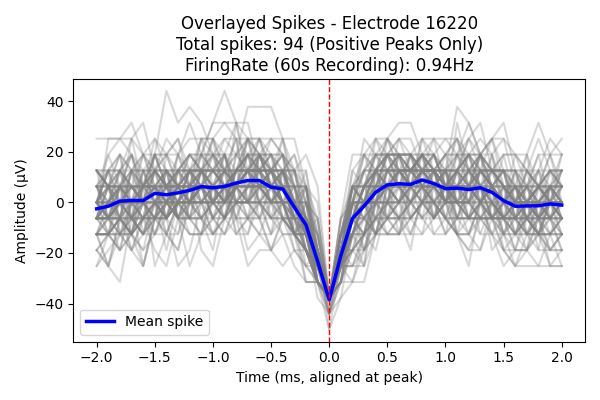

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Electrode and spike info
fs = recording_chunk.get_sampling_frequency()  # Hz

electrode_id = 16220  # Change as needed
if electrode_id in electrodes:
    ch_idx = np.where(np.array(electrodes) == electrode_id)[0][0]
else:
    raise ValueError(f"Electrode {electrode_id} not found.")

trace = traces[:, ch_idx]

# Detect negative peaks
neg_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier=4)
# Detect positive peaks
pos_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="pos", std_multiplier=4)

#all_spike_inds = np.sort(np.concatenate([neg_spike_inds, pos_spike_inds]))

# Spike statistics
n_samples = traces.shape[0]
duration_sec = n_samples / fs
spike_rate = len(neg_spike_inds) / duration_sec
print(f"Recording length: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)")
print(f"Total spikes detected: {len(neg_spike_inds)}")
print(f"Spike rate: {spike_rate:.2f} Hz")

if len(neg_spike_inds) == 0:
    print(f"No spikes detected for electrode {electrode_id}.")
else:
    # Parameters
    window_ms = 2   # total window half-width
    window_samples = int(window_ms * fs / 1000)
    t_axis = np.arange(-window_samples, window_samples + 1) / fs * 1000  # in ms, centered at 0
    
    spike_waveforms = []

    # Collect aligned windows
    for peak_idx in neg_spike_inds:
        start = max(0, peak_idx - window_samples)
        end = min(traces.shape[0], peak_idx + window_samples + 1)

        if end - start == 2 * window_samples + 1:  # only include full windows
            trace_window = traces[start:end, ch_idx]
            spike_waveforms.append(trace_window)

    spike_waveforms = np.array(spike_waveforms)

    # Plot all spikes
    plt.figure(figsize=(6, 4))
    for w in spike_waveforms:
        plt.plot(t_axis, w, color="gray", alpha=0.3)

    # Plot mean spike template
    mean_waveform = spike_waveforms.mean(axis=0)
    plt.plot(t_axis, mean_waveform, color="blue", linewidth=2.5, label="Mean spike")

    plt.axvline(0, color="red", linestyle="--", linewidth=1)
    plt.xlabel("Time (ms, aligned at peak)")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"Overlayed Spikes - Electrode {electrode_id}\nTotal spikes: {len(spike_waveforms)} (Positive Peaks Only)\nFiringRate (60s Recording): {spike_rate:.2f}Hz")
    plt.legend()
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_21/2546590413.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(other_electrodes))


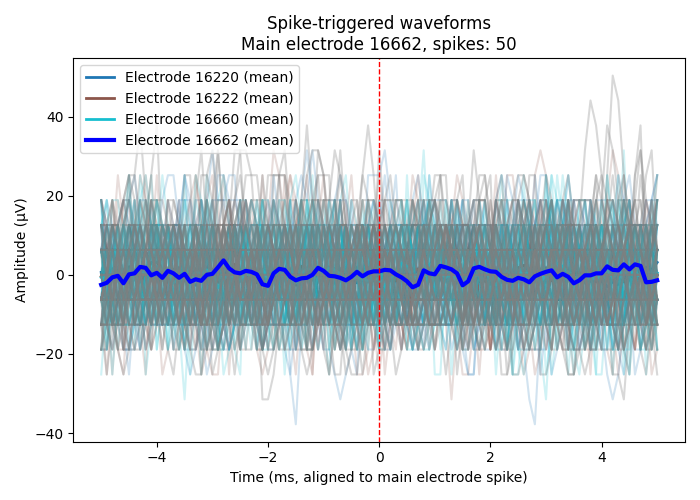

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multielectrode_spikes(traces, fs, main_electrode, other_electrodes, electrodes,
                               spike_inds, window_ms=10):
    """
    Overlay spike windows from a main electrode and other electrodes, aligned to main electrode spikes.
    
    Parameters
    ----------
    traces : np.ndarray
        Shape (n_samples, n_channels), voltage traces.
    fs : float
        Sampling frequency (Hz).
    main_electrode : int
        Electrode ID to align spikes on.
    other_electrodes : list of int
        Electrode IDs to overlay.
    electrodes : list or np.ndarray
        List of electrode IDs in order of traces.
    spike_inds : np.ndarray
        Indices of detected spikes on main electrode.
    window_ms : float
        Window around each spike in ms.
    """
    if len(spike_inds) == 0:
        print(f"No spikes detected for electrode {main_electrode}.")
        return

    # Convert ms → samples
    window_samples = int(window_ms * fs / 1000)
    t_axis = np.arange(-window_samples, window_samples + 1) / fs * 1000  # ms

    # Index for main electrode
    main_idx = np.where(np.array(electrodes) == main_electrode)[0][0]
    
    # Indices for other electrodes
    other_idxs = [np.where(np.array(electrodes) == e)[0][0] for e in other_electrodes]

    # Collect waveforms
    main_waveforms = []
    other_waveforms = {e: [] for e in other_electrodes}

    for peak_idx in spike_inds:
        start = peak_idx - window_samples
        end = peak_idx + window_samples + 1
        if start >= 0 and end <= traces.shape[0]:
            # Main electrode
            main_waveforms.append(traces[start:end, main_idx])
            # Other electrodes
            for e, idx in zip(other_electrodes, other_idxs):
                other_waveforms[e].append(traces[start:end, idx])

    # Convert to arrays
    main_waveforms = np.array(main_waveforms)
    for e in other_waveforms:
        other_waveforms[e] = np.array(other_waveforms[e])

    # Plot
    plt.figure(figsize=(7, 5))

    # Plot other electrodes (faint, many lines)
    cmap = plt.cm.get_cmap("tab10", len(other_electrodes))
    for i, e in enumerate(other_electrodes):
        for w in other_waveforms[e]:
            plt.plot(t_axis, w, color=cmap(i), alpha=0.2)
        mean_w = other_waveforms[e].mean(axis=0)
        plt.plot(t_axis, mean_w, color=cmap(i), linewidth=2, label=f"Electrode {e} (mean)")

    # Plot main electrode (spikes + mean bold)
    for w in main_waveforms:
        plt.plot(t_axis, w, color="gray", alpha=0.3)
    plt.plot(t_axis, main_waveforms.mean(axis=0), color="blue", linewidth=3, label=f"Electrode {main_electrode} (mean)")

    plt.axvline(0, color="red", linestyle="--", linewidth=1)
    plt.xlabel("Time (ms, aligned to main electrode spike)")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"Spike-triggered waveforms\nMain electrode {main_electrode}, spikes: {len(main_waveforms)}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Usage ---
fs = recording_chunk.get_sampling_frequency()
main_electrode = 16662
other_electrodes = [16220, 16222, 16660]

# Use your detected peaks for main electrode
plot_multielectrode_spikes(traces, fs, main_electrode, other_electrodes,
                           electrodes, all_spike_inds, window_ms=5)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Electrode and spike info
fs = recording_chunk.get_sampling_frequency()  # Hz

electrode_id = 16662  # Change as needed
if electrode_id in electrodes:
    ch_idx = np.where(np.array(electrodes) == electrode_id)[0][0]
else:
    raise ValueError(f"Electrode {electrode_id} not found.")

trace = traces[:, ch_idx]

# Detect negative peaks
neg_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier=4)
# Detect positive peaks
pos_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="pos", std_multiplier=4)

all_spike_inds = np.sort(np.concatenate([neg_spike_inds, pos_spike_inds]))

if len(all_spike_inds) == 0:
    print(f"No spikes detected for electrode {electrode_id}.")
else:
    for peak_idx in all_spike_inds:
        window_ms = 10
        window_samples = int(window_ms * fs / 1000)
        start = max(0, peak_idx - window_samples)
        end = min(traces.shape[0], peak_idx + window_samples + 1)
        trace_window = traces[start:end, ch_idx]
        time_axis = (np.arange(start, end) / fs)  # seconds, absolute time in recording
        peak_time_s = peak_idx / fs  # seconds
        plt.figure(figsize=(6, 3))
        plt.plot(time_axis, trace_window, label=f'Electrode {electrode_id}')
        plt.axvline(peak_time_s, color='red', linestyle='--', label='Detected Peak')
        plt.xlabel('Time (s, absolute in recording)')
        plt.ylabel('Amplitude (µV)')
        plt.title(f'Peak at Electrode {electrode_id} (Sample {peak_idx}, Time {peak_time_s:.4f} s)')
        plt.legend()
        plt.tight_layout()
        plt.show()
    n_samples = traces.shape[0]
    duration_sec = n_samples / fs
    print(f"Recording length: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)")
    spike_rate = len(all_spike_inds) / duration_sec  # spikes per second (Hz)
    print(f"Spike rate: {spike_rate:.2f} Hz")
    print(f"Total spikes detected: {len(all_spike_inds)}")




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fs = recording_chunk.get_sampling_frequency()  # Hz

main_electrode = 16662
other_electrodes = [16220, 16222, 16660]

# Get indices
if main_electrode in electrodes:
    main_idx = np.where(np.array(electrodes) == main_electrode)[0][0]
else:
    raise ValueError(f"Electrode {main_electrode} not found.")

other_idxs = [np.where(np.array(electrodes) == e)[0][0] for e in other_electrodes]

trace_main = traces[:, main_idx]

# Detect spikes
neg_spike_inds, _ = detect_peaks_stddev(trace_main, peak_sign="neg", std_multiplier=4)
pos_spike_inds, _ = detect_peaks_stddev(trace_main, peak_sign="pos", std_multiplier=4)
all_spike_inds = np.sort(np.concatenate([neg_spike_inds, pos_spike_inds]))

# Window parameters
window_ms = 2
window_samples = int(window_ms * fs / 1000)

if len(all_spike_inds) == 0:
    print(f"No spikes detected for electrode {main_electrode}.")
else:
    for peak_idx in all_spike_inds:
        start = peak_idx - window_samples
        end = peak_idx + window_samples + 1
        if start < 0 or end > traces.shape[0]:
            continue  # skip if window goes out of bounds

        time_axis = (np.arange(start, end) - peak_idx) / fs * 1000  # centered at 0 ms

        # Main electrode waveform
        waveform_main = traces[start:end, main_idx]

        # Other electrodes waveforms
        waveforms_other = [traces[start:end, idx] for idx in other_idxs]

        # Plot
        plt.figure(figsize=(6, 3))
        plt.plot(time_axis, waveform_main, color="blue", linewidth=2.5, label=f'Main {main_electrode}')
        colors = ["green", "orange", "purple"]  # adjust dynamically if more electrodes
        for w, c, e in zip(waveforms_other, colors, other_electrodes):
            plt.plot(time_axis, w, color=c, alpha=0.5, linewidth=1.5, label=f'Electrode {e}')

        plt.axvline(0, color="red", linestyle="--", linewidth=1)
        plt.xlabel("Time (ms, aligned at main electrode peak)")
        plt.ylabel("Amplitude (µV)")
        plt.title(f"Spike at Electrode {main_electrode} (Sample {peak_idx})")
        plt.legend()
        plt.tight_layout()
        plt.show()

    n_samples = traces.shape[0]
    duration_sec = n_samples / fs
    spike_rate = len(all_spike_inds) / duration_sec
    print(f"Recording length: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)")
    print(f"Spike rate: {spike_rate:.2f} Hz")
    print(f"Total spikes detected: {len(all_spike_inds)}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

fs = recording_chunk.get_sampling_frequency()  # Hz

main_electrode = 16662
other_electrodes = [16220, 16222, 16660]

# Get indices
if main_electrode in electrodes:
    main_idx = np.where(np.array(electrodes) == main_electrode)[0][0]
else:
    raise ValueError(f"Electrode {main_electrode} not found.")

other_idxs = [np.where(np.array(electrodes) == e)[0][0] for e in other_electrodes]

trace_main = traces[:, main_idx]

# Detect spikes
neg_spike_inds, _ = detect_peaks_stddev(trace_main, peak_sign="neg", std_multiplier=4)
pos_spike_inds, _ = detect_peaks_stddev(trace_main, peak_sign="pos", std_multiplier=4)
all_spike_inds = np.sort(np.concatenate([neg_spike_inds, pos_spike_inds]))

# Window parameters
window_ms = 2
window_samples = int(window_ms * fs / 1000)

# Output folder
output_folder = "/home/shruti/Downloads/KCNT1_MEAslices/outputs"
os.makedirs(output_folder, exist_ok=True)
output_pdf_path = os.path.join(output_folder, f"Electrode_{main_electrode}_spikes_2ms.pdf")

if len(all_spike_inds) == 0:
    print(f"No spikes detected for electrode {main_electrode}.")
else:
    # Open PDF file to save all figures
    with PdfPages(output_pdf_path) as pdf:
        for peak_idx in all_spike_inds:
            start = peak_idx - window_samples
            end = peak_idx + window_samples + 1
            if start < 0 or end > traces.shape[0]:
                continue  # skip if window goes out of bounds

            time_axis = (np.arange(start, end) - peak_idx) / fs * 1000  # ms, centered at 0

            # Main electrode waveform
            waveform_main = traces[start:end, main_idx]

            # Other electrodes waveforms
            waveforms_other = [traces[start:end, idx] for idx in other_idxs]

            # Plot
            fig, ax = plt.subplots(figsize=(6, 3))
            ax.plot(time_axis, waveform_main, color="blue", linewidth=2.5, label=f'Main {main_electrode}')
            colors = plt.cm.tab10.colors  # enough colors for multiple electrodes
            for i, (w, e) in enumerate(zip(waveforms_other, other_electrodes)):
                ax.plot(time_axis, w, color=colors[i % 10], alpha=0.5, linewidth=1.5, label=f'Electrode {e}')

            ax.axvline(0, color="red", linestyle="--", linewidth=1)
            ax.set_xlabel("Time (ms, aligned at main electrode peak)")
            ax.set_ylabel("Amplitude (µV)")
            ax.set_title(f"Spike at Electrode {main_electrode} (Sample {peak_idx})")
            ax.legend()
            plt.tight_layout()

            # Save current figure to PDF
            pdf.savefig(fig)
            plt.close(fig)  # close to free memory

    print(f"All spike figures saved to: {output_pdf_path}")


In [ ]:
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import numpy as np

# Select electrode and get channel index
# Change electrode_id as needed
electrode_id = 25206
if electrode_id in electrodes:
    ch_idx = np.where(np.array(electrodes) == electrode_id)[0][0]
else:
    raise ValueError(f"Electrode {electrode_id} not found.")

# Get trace and detected peaks (both pos and neg)
trace = traces[:, ch_idx]
neg_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier=5)
pos_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="pos", std_multiplier=5)
all_spike_inds = np.sort(np.concatenate([neg_spike_inds, pos_spike_inds]))

# Plot interactive trace with peaks overlaid
fig, ax = plt.subplots(figsize=(12, 4))
time_axis = np.arange(trace.shape[0]) / fs  # seconds
ax.plot(time_axis, trace, label=f'Electrode {electrode_id}')
ax.plot(time_axis[all_spike_inds], trace[all_spike_inds], 'rv', label='Detected Peaks')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (µV)')
ax.set_title(f'Interactive Trace with Detected Peaks (Electrode {electrode_id})')
ax.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# List of electrode IDs you want to plot
electrode_ids = [15746, 15748, 16186, 16188]  # Add as many as you want

time_window_sec = 100  # Set to 200 seconds
num_samples = int(fs * time_window_sec)
plt.figure(figsize=(12, 6))
for electrode_id in electrode_ids:
    # Find the index of the electrode in your electrodes list/array
    ch_idx = list(electrodes).index(electrode_id)
    plt.plot(traces[:, ch_idx], label=f'Electrode {electrode_id}')

plt.xlabel('Sample')
plt.ylabel('Signal (µV)')
plt.title('Traces for Selected Electrodes')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = recording_chunk.get_sampling_frequency()  # Hz
main_electrode_id = 16186  # The electrode with detected peaks
background_electrode_ids = [15746, 15748, 16188]  # Other electrodes to show as background
window_ms = 10

if main_electrode_id in electrodes:
    ch_idx = np.where(np.array(electrodes) == main_electrode_id)[0][0]
else:
    raise ValueError(f"Electrode {main_electrode_id} not found.")

trace = traces[:, ch_idx]
neg_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier=4)
pos_spike_inds, _ = detect_peaks_stddev(trace, peak_sign="pos", std_multiplier=4)
all_spike_inds = np.sort(np.concatenate([neg_spike_inds, pos_spike_inds]))

for peak_idx in all_spike_inds:
    window_samples = int(window_ms * fs / 1000)
    start = max(0, peak_idx - window_samples)
    end = min(traces.shape[0], peak_idx + window_samples + 1)
    time_axis = (np.arange(start, end) / fs)  # seconds, absolute time in recording

    plt.figure(figsize=(8, 4))
    # Plot background traces
    for bg_electrode_id in background_electrode_ids:
        if bg_electrode_id in electrodes:
            bg_ch_idx = list(electrodes).index(bg_electrode_id)
            bg_trace_window = traces[start:end, bg_ch_idx]
            plt.plot(
                time_axis, bg_trace_window,
                label=f'Electrode {bg_electrode_id} (background)',
                color='gray', alpha=0.3
            )
    # Plot main trace
    trace_window = traces[start:end, ch_idx]
    peak_time_s = peak_idx / fs
    plt.plot(
        time_axis, trace_window,
        label=f'Electrode {main_electrode_id} (peak)',
        color='blue', linewidth=2
    )
    plt.axvline(peak_time_s, color='red', linestyle='--', label='Detected Peak')
    plt.xlabel('Time (s, absolute in recording)')
    plt.ylabel('Amplitude (µV)')
    plt.title(f'Peak at Electrode {main_electrode_id} (Sample {peak_idx}, Time {peak_time_s:.4f} s)')
    plt.legend()
    plt.tight_layout()
    plt.show()

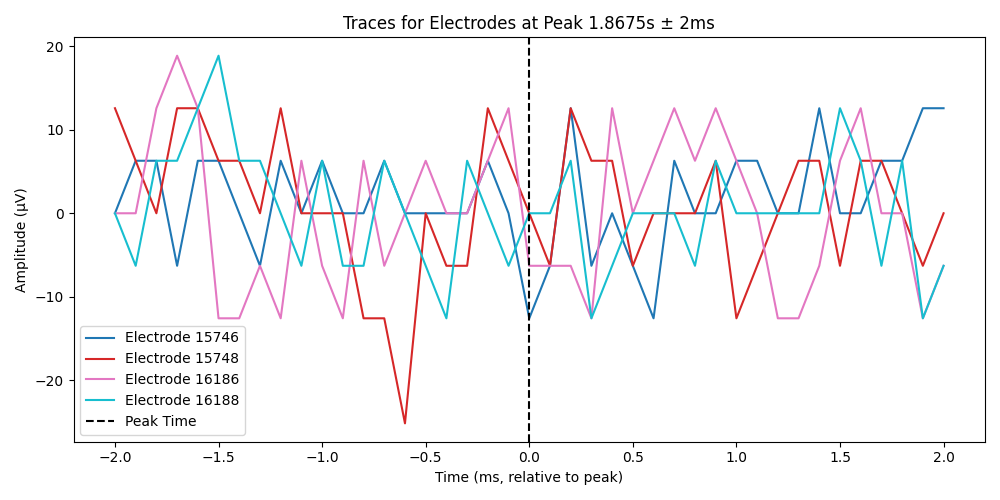

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = recording_chunk.get_sampling_frequency()  # Hz
electrode_ids = [15746, 15748, 16186, 16188]  # List of electrodes to plot
peak_time_s = 1.8675  # Example peak time in seconds
window_ms = 2  # Window size in ms (±2ms)
window_samples = int(window_ms * fs / 1000)

# Find the sample index for the peak
peak_idx = int(peak_time_s * fs)
start = max(0, peak_idx - window_samples)
end = min(traces.shape[0], peak_idx + window_samples + 1)
time_axis = (np.arange(start, end) - peak_idx) / fs * 1000  # Time axis in ms, centered at peak

plt.figure(figsize=(10, 5))
colors = plt.cm.tab10(np.linspace(0, 1, len(electrode_ids)))  # Unique color for each electrode

for i, electrode_id in enumerate(electrode_ids):
    if electrode_id in electrodes:
        ch_idx = list(electrodes).index(electrode_id)
        trace_window = traces[start:end, ch_idx]
        plt.plot(
            time_axis, trace_window,
            label=f'Electrode {electrode_id}',
            color=colors[i]
        )

plt.axvline(0, color='black', linestyle='--', label='Peak Time')
plt.xlabel('Time (ms, relative to peak)')
plt.ylabel('Amplitude (µV)')
plt.title(f'Traces for Electrodes at Peak {peak_time_s:.4f}s ± {window_ms}ms')
plt.legend()
plt.tight_layout()
plt.show()

# spike sorting

In [13]:
#aggregated_rec= aggregated_rec.save(fodler="./sorting/recordingtest",progress_bar=True,verbose=True)

default_KS2_params = si.get_default_sorter_params('kilosort2')
print(default_KS2_params)
#default_KS2_params['keep_good_only'] = True
default_KS2_params['detect_threshold'] = 4.5
# default_KS2_params['projection_threshold']=[18, 10]
default_KS2_params['n_jobs'] = 32
all_channels = recording_chunk.get_channel_ids()
selected_channel_ids = [ch for ch in [135, 219, 495, 235] if ch in all_channels]

recording_chunk2 = recording_chunk.channel_slice(channel_ids=all_channels)
run_sorter = si.run_sorter_local(
    sorter_name="kilosort2",
    recording=recording_chunk2,
    output_folder='/mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_SpikeSorting_Outputs/',
    delete_output_folder=False,
    verbose=True,
    with_output=True,
    **default_KS2_params
)

# global_job_kwargs = dict(n_jobs=32, total_memory="8G", progress_bar=True)
# si.set_global_job_kwargs(**global_job_kwargs)
#run_sorter=si.run_sorter_local(sorter_name="kilosort2",recording=recording_chunk, output_folder='/mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_SpikeSorting_Outputs/', delete_output_folder=False,verbose=True,with_output=True,**default_KS2_params)


{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'whiteningRange': 32, 'momentum': [20.0, 400.0], 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'lam': 10.0, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': ('matlab_files',), 'delete_recording_dat': False, 'n_jobs': 1, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}


/tmp/ipykernel_178/1033749005.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  selected_channel_ids = [ch for ch in [135, 219, 495, 235] if ch in all_channels]



RUNNING SHELL SCRIPT: /mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_SpikeSorting_Outputs/sorter_output/run_kilosort2.sh
Time   0s. Determining good channels.. 

found 5841 threshold crossings in 100.00 seconds of data 

found 762 bad channels 

Time   8s. Computing whitening matrix.. 

Getting channel whitening matrix... 

Channel-whitening matrix computed. 

Time   9s. Loading raw data and applying filters... 

Time  11s. Finished preprocessing 16 batches. 

random seed for clusterSingleBatches: 1

Obtained 7 PC waveforms in 0.12 seconds 

time 0.16, pre clustered 1 / 16 batches 

time 0.02, compared 1 / 16 batches 

time 3.68, Re-ordered 16 batches. 

Time   4s. Optimizing templates ...

3.93 sec, 1 / 16 batches, 4 units, nspks: 2.6756, mu: 17.8751, nst0: 3, merges: 0.0000, 0.0000 

Elapsed time is 4.874145 seconds.

----------------------------------------Index in position 1 is invalid. Array indices must be positive integers or logical values.
Error running kilosort2


SpikeSortingError: Spike sorting error trace:
Traceback (most recent call last):
  File "/home/miniconda3/lib/python3.8/site-packages/spikeinterface/sorters/basesorter.py", line 257, in run_from_folder
    SorterClass._run_from_folder(sorter_output_folder, sorter_params, verbose)
  File "/home/miniconda3/lib/python3.8/site-packages/spikeinterface/sorters/external/kilosortbase.py", line 217, in _run_from_folder
    raise Exception(f"{cls.sorter_name} returned a non-zero exit code")
Exception: kilosort2 returned a non-zero exit code

Spike sorting failed. You can inspect the runtime trace in /mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_SpikeSorting_Outputs/spikeinterface_log.json.

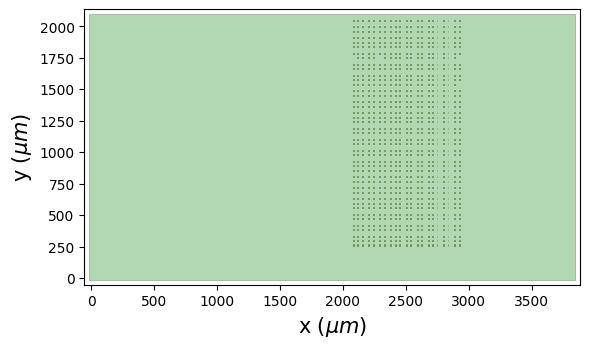

/home/miniconda3/lib/python3.8/site-packages/spikeinterface/core/channelslice.py:36: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  chan_id in parents_chan_ids for chan_id in self._channel_ids


AssertionError: ChannelSliceRecording : channel ids are not all in parents

In [ ]:
import spikeinterface.full as si
import matplotlib.pyplot as plt

# Plot all channels
si.plot_probe_map(recording_chunk)
plt.show()

# Or just your selected 4 channels
recording_chunk2 = recording_chunk.channel_slice(channel_ids=[135, 219, 495, 235])
si.plot_probe_map(recording_chunk2)
plt.show()


In [11]:
# Show all channels in the recording
print("Channel IDs in recording:", recording_chunk.channel_ids)

# Check if your electrodes exist
desired_electrodes = [16660, 16662, 166222, 16220]
existing_electrodes = [ch for ch in desired_electrodes if ch in recording_chunk.channel_ids]
print("Existing electrodes in recording:", existing_electrodes)


Channel IDs in recording: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '37' '38' '39' '40' '41' '42' '43' '44' '45'
 '46' '47' '48' '49' '50' '51' '53' '54' '55' '56' '57' '58' '59' '60'
 '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72' '73' '74'
 '75' '76' '77' '78' '79' '81' '82' '83' '84' '85' '86' '87' '88' '89'
 '90' '91' '93' '94' '95' '97' '98' '99' '100' '101' '102' '103' '105'
 '106' '107' '108' '109' '110' '111' '112' '113' '114' '115' '116' '117'
 '118' '119' '121' '122' '123' '125' '126' '127' '129' '130' '131' '133'
 '134' '135' '137' '138' '139' '141' '142' '143' '145' '146' '147' '149'
 '150' '151' '153' '154' '155' '157' '158' '159' '161' '162' '163' '165'
 '166' '167' '169' '170' '171' '173' '174' '175' '177' '178' '179' '181'
 '182' '183' '185' '186' '187' '189' '190' '191' '193' '194' '195' '197'
 '198' '199' '201' '202' '203' '205' '2

/tmp/ipykernel_178/2675828404.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  existing_electrodes = [ch for ch in desired_electrodes if ch in recording_chunk.channel_ids]


In [6]:
pip install kilosort

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 74.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 22.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 37.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 20.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 14.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━

In [17]:
conda install python=3.8.10


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/miniconda3

  added / updated specs:
    - python=3.8.10


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boltons-23.0.0             |   py38h06a4308_0         426 KB
    ca-certificates-2025.9.9   |       h06a4308_0         127 KB
    certifi-2024.8.30          |   py38h06a4308_0         162 KB
    cffi-1.15.0                |   py38hd667e15_1         224 KB
    conda-23.5.2               |   py38h06a4308_0         1.0 MB
    jsonpatch-1.33             |   py38h06a4308_1          31 KB
    jsonpointer-2.1            |     pyhd3eb1b0_0           9 KB
    libffi-3.3                 |       he6710b0_2          50 KB
    openssl-1.1.1w             |       h7f8727e_0         3.7 MB
    packaging-24.1             |   py38h06a4308_0 

In [6]:
from pathlib import Path

import numpy as np
import pandas as pd

from kilosort.io import load_ops




# NOTE: Be sure to update this filepath if you want the data downloaded to
#       a specific location.
#SAVE_PATH = DOWNLOADS_DIR / '.test_data' / 'ZFM-02370_mini.imec0.ap.short.bin'
# outputs saved to results_dir
results_dir = Path("/mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_KS4")
#ops = load_ops(results_dir / 'ops.npy')
camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(results_dir / 'channel_map.npy')
templates =  np.load(results_dir / 'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / 'amplitudes.npy')
st = np.load(results_dir / 'spike_times.npy')
clu = np.load(results_dir / 'spike_clusters.npy')
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
#dshift = ops['dshift']

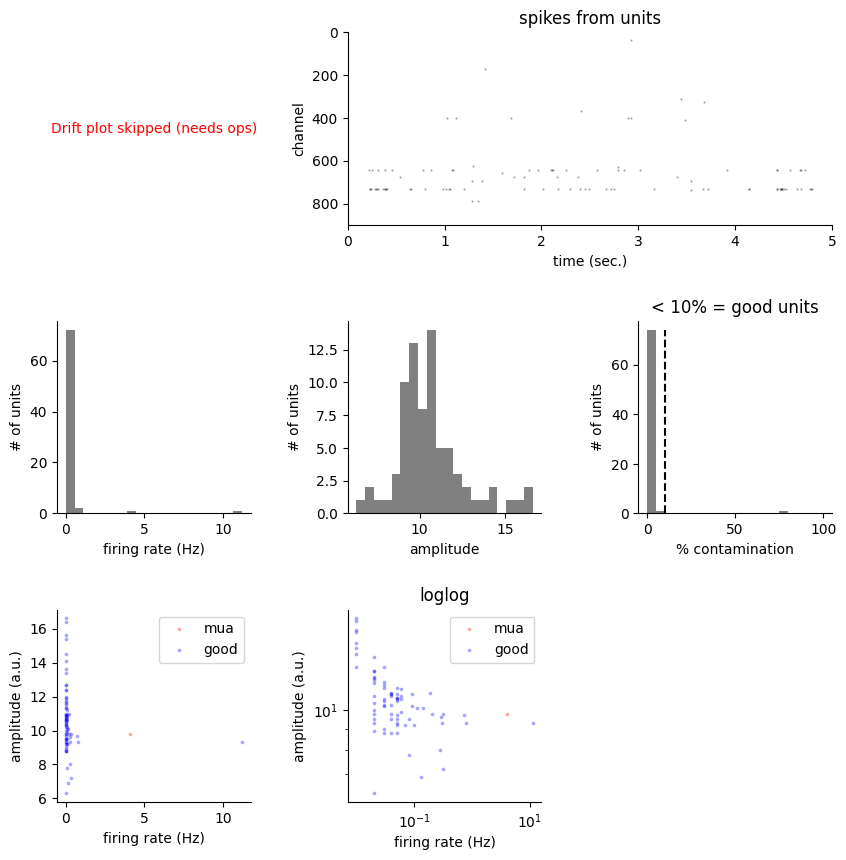

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


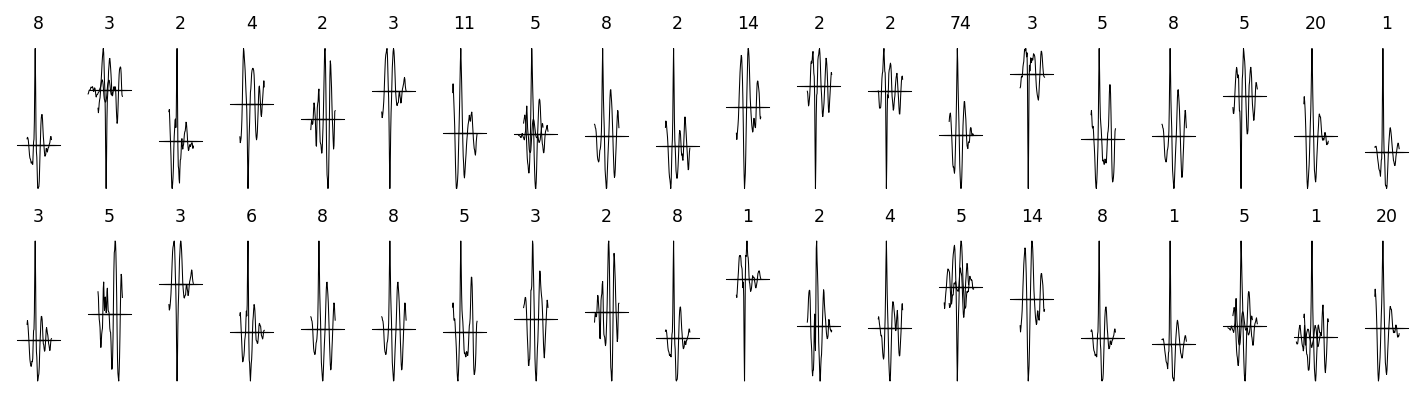

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


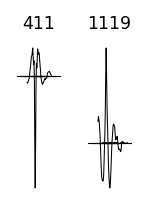

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
import numpy as np

rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

# ---- Drift plot (SKIPPED, needs ops) ----
ax = fig.add_subplot(grid[0,0])
ax.text(0.5, 0.5, "Drift plot skipped (needs ops)", 
        ha='center', va='center', fontsize=10, color='red')
ax.set_axis_off()

# ---- Spikes scatter ----
ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > 30000*5)[0][0]   # 5 sec worth of spikes
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], 
           s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

# ---- Histograms ----
ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

# ---- Amplitude vs firing rate ----
for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct < 10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

plt.show()

# ---- Waveform plots ----
nc = 16 # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]

gstr = ['good', 'mua']
for j in range(2):
    print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('title = number of spikes from each unit')
    units = good_units if j==0 else mua_units
    fig = plt.figure(figsize=(12,3), dpi=150)
    grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(min(40, len(units))):  # cap at 40 plots
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()
        cb = chan_best[wi]
        nsp = (clu==wi).sum()

        ax = fig.add_subplot(grid[k//20, k%20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb-nc//2)
        ic1 = min(n_chan, cb+nc//2)
        wv = wv[:, ic0:ic1]

        # Fake probe positions (since ops['probe'] not loaded)
        x0 = np.arange(ic0, ic1)
        y0 = np.zeros_like(x0)

        amp = 4
        for ii, (xi,yi) in enumerate(zip(x0,y0)):
            t = np.arange(-wv.shape[0]//2,wv.shape[0]//2,1,'float32')
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

        ax.set_title(f'{nsp}', fontsize='small')
        ax.axis('off')
    plt.show()


~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


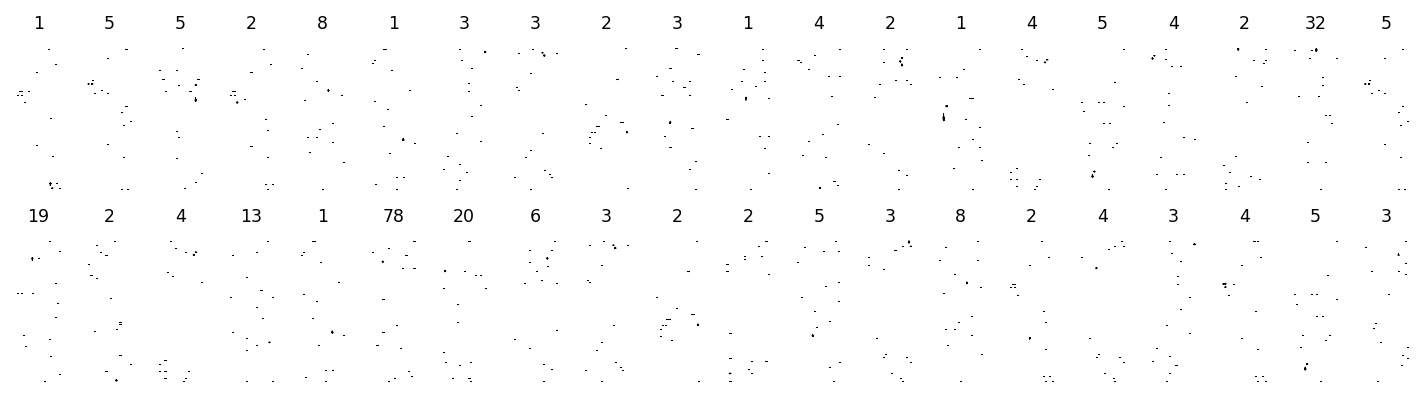

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


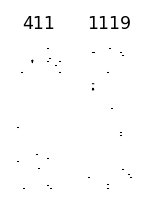

In [13]:
# Try to load channel positions
try:
    chan_pos = np.load(results_dir / "channel_positions.npy")  # shape (n_channels, 2)
    xc, yc = chan_pos[:, 0], chan_pos[:, 1]
except FileNotFoundError:
    print("⚠️ channel_positions.npy not found, falling back to linear x-axis")
    xc = np.arange(chan_map.shape[0])
    yc = np.zeros_like(xc)

nc = 16 # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]

gstr = ['good', 'mua']
for j in range(2):
    print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('title = number of spikes from each unit')
    units = good_units if j==0 else mua_units
    fig = plt.figure(figsize=(12,3), dpi=150)
    grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(min(40, len(units))):  # cap at 40 plots
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()
        cb = chan_best[wi]
        nsp = (clu==wi).sum()

        ax = fig.add_subplot(grid[k//20, k%20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb-nc//2)
        ic1 = min(n_chan, cb+nc//2)
        wv = wv[:, ic0:ic1]
        x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

        amp = 4
        for ii, (xi,yi) in enumerate(zip(x0,y0)):
            t = np.arange(-wv.shape[0]//2, wv.shape[0]//2, 1, 'float32')
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

        ax.set_title(f'{nsp}', fontsize='small')
        ax.axis('off')
    plt.show()


In [16]:
print(templates)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
p5in6

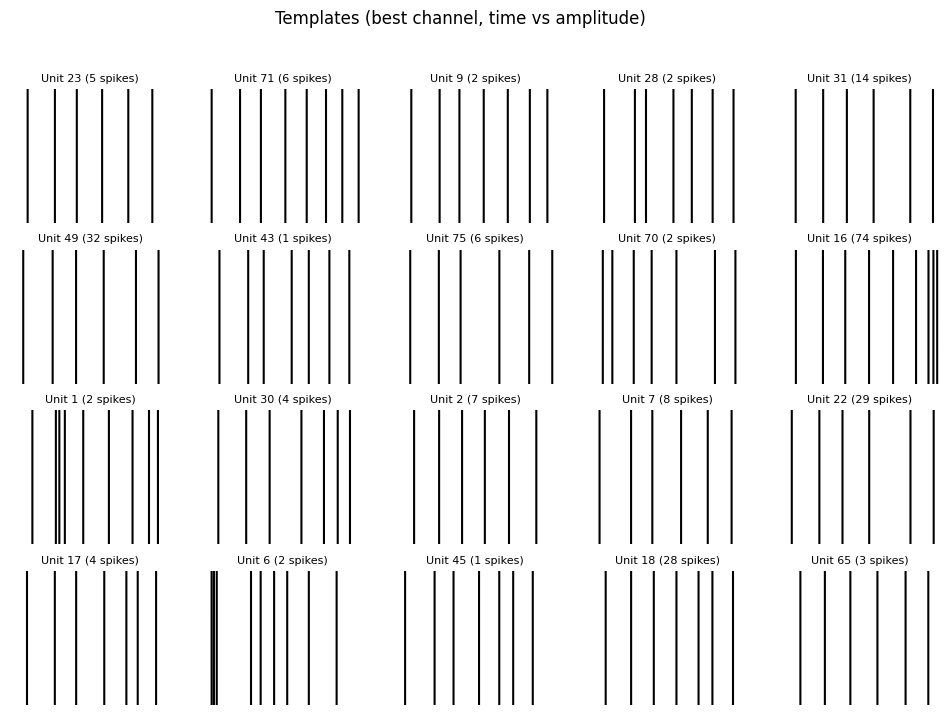

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# assume templates shape = (n_units, n_timepoints, n_channels)
n_units, n_timepoints, n_channels = templates.shape

fs = 30000  # sampling rate (Hz), adjust if yours is different
time = np.arange(n_timepoints) / fs * 1000  # in ms

# choose some random good units
units_to_plot = np.random.choice(good_units, size=20, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(12,8), sharex=True, sharey=True)
axes = axes.ravel()

for i, unit in enumerate(units_to_plot):
    wv = templates[unit]   # (timepoints x channels)
    cb = chan_best[unit]   # best channel index
    trace = wv[:, cb]      # waveform on best channel
    
    axes[i].plot(time, trace * 1e6, color='k')  # scale to µV if needed
    axes[i].set_title(f'Unit {unit} ({(clu==unit).sum()} spikes)', fontsize=8)
    axes[i].set_xlim([time[0], time[-1]])
    axes[i].set_ylim([-100, 100])  # adjust depending on scaling

for ax in axes:
    ax.axis('off')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude (µV)')
plt.suptitle('Templates (best channel, time vs amplitude)')
plt.show()


In [66]:
unit = 69 
print(chan_best[unit])

356


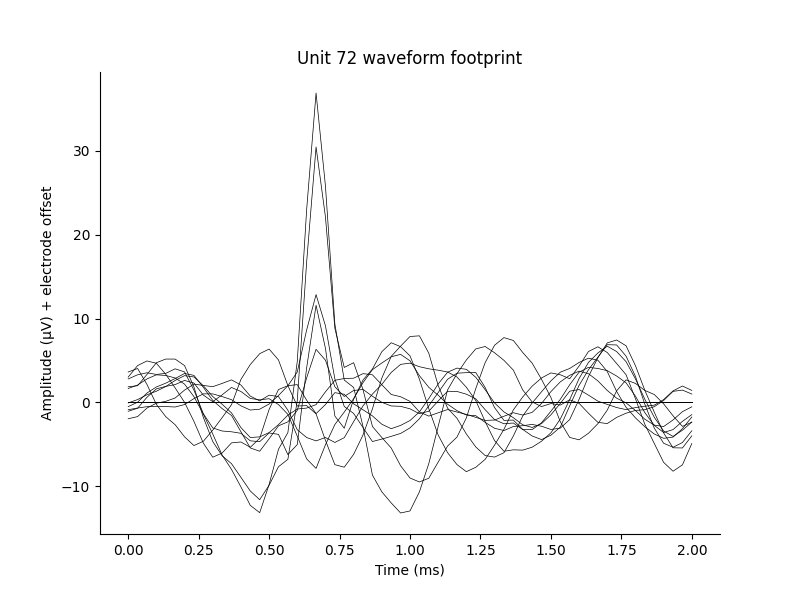

In [63]:
unit = 72
wv = templates[unit]   # (timepoints x channels)
cb = chan_best[unit]

fs = 30000
time = np.arange(wv.shape[0]) / fs * 1000  # ms
fig, ax = plt.subplots(figsize=(8,6))

amp_scale = 10  # vertical scaling for clarity
for ch in range(wv.shape[1]):
    trace = wv[:, ch] *10
    ax.plot(time, trace, lw=0.5, color='k')


ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (µV) + electrode offset')  # <-- clearer µV label
ax.set_title(f'Unit {unit} waveform footprint')
plt.show()


In [43]:
unit = good_units[68]
best_ch = chan_best[unit]  # this is the channel used for this unit
print(f"Unit {unit} best channel: {best_ch}")
print(f"Best channel coordinates: {locs[best_ch]}")


Unit 70 best channel: 363
Best channel coordinates: [2747.5 1540. ]


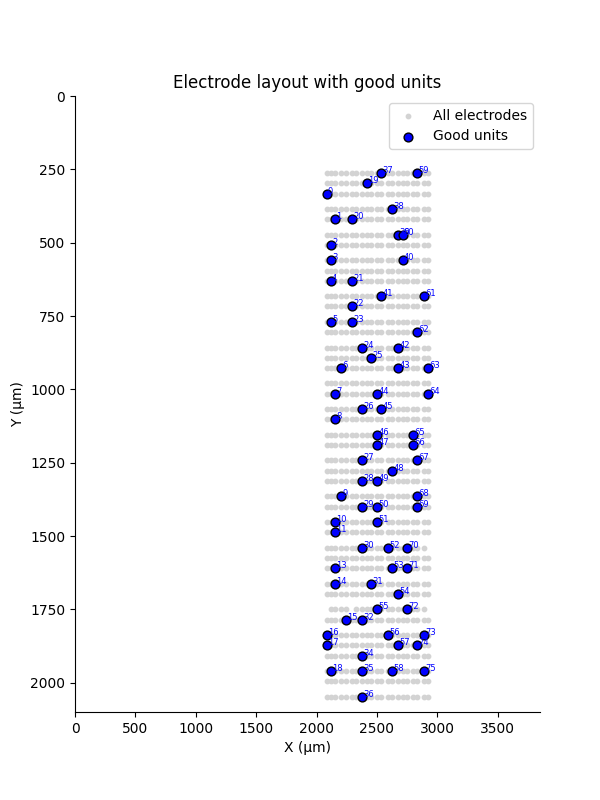

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Example: suppose you already have these
# locs: (n_channels, 2) array of electrode positions [x,y]
# channel_ids: (n_channels,) list of channel ids
# good_units: indices of good units
# chan_best: best channel index per unit

# Plot electrode layout
fig, ax = plt.subplots(figsize=(6,8))
ax.scatter(locs[:,0], locs[:,1], c="lightgray", s=10, label="All electrodes")

# Overlay good unit positions
good_chs = chan_best[good_units]   # best channel for each good unit
good_x = locs[good_chs,0]
good_y = locs[good_chs,1]

ax.scatter(good_x, good_y, c="blue", s=40, marker="o", edgecolors="k", label="Good units")

# Annotate each unit with its ID (optional)
for unit, x, y in zip(good_units, good_x, good_y):
    ax.text(x+10, y, str(unit), fontsize=6, color="blue")  # +10 shifts label a bit
ax.invert_yaxis()   # match typical MEA layout

plt.xlim([0,3850])
plt.ylim(2100,0)
ax.set_title("Electrode layout with good units")
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
ax.legend()
plt.show()


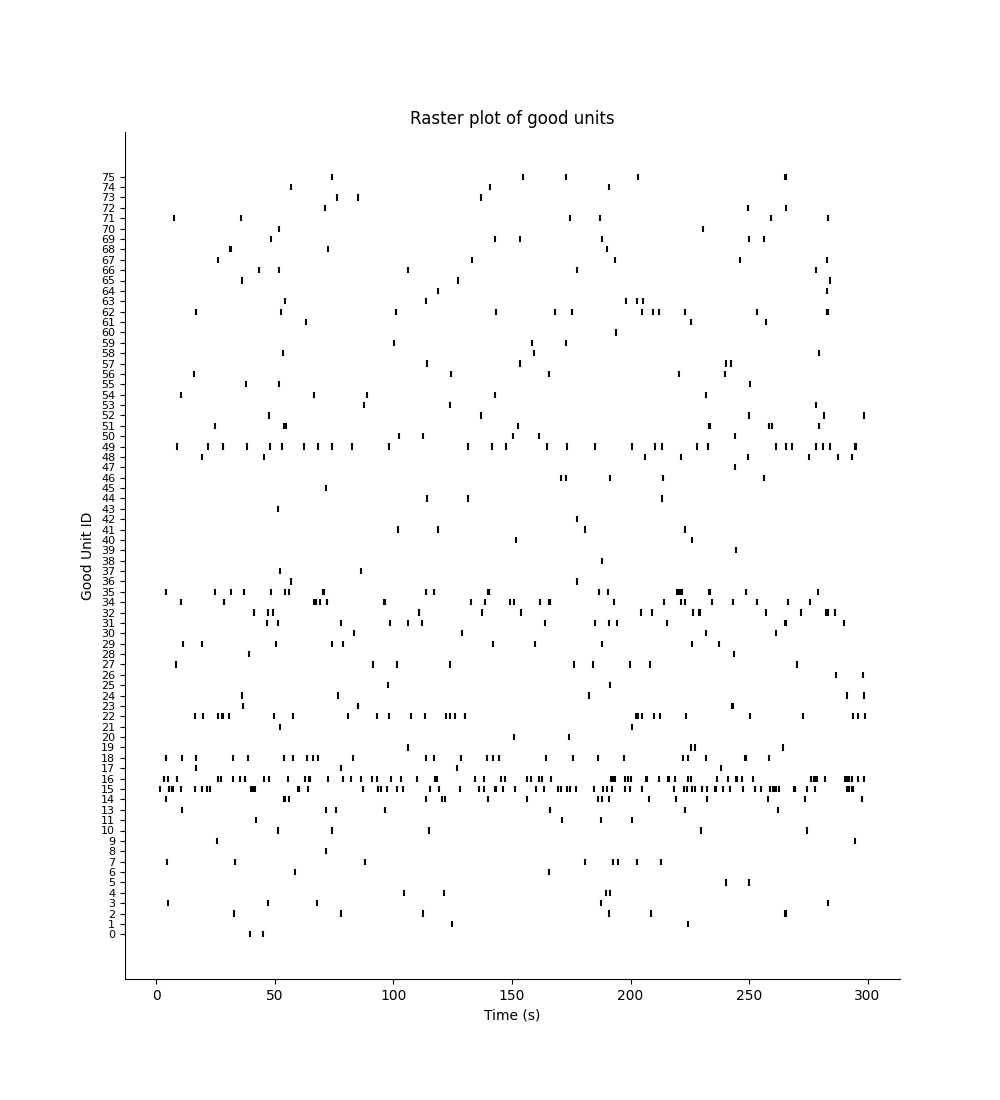

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Convert spike times to seconds
spike_times_sec = st / 10000.0   # replace 30000 with ops['fs'] if available

# Filter spikes for only good units
mask = np.isin(clu, good_units)
good_spike_times = spike_times_sec[mask]
good_spike_clusters = clu[mask]

# Raster plot
plt.figure(figsize=(10,11))
plt.eventplot(
    [good_spike_times[good_spike_clusters == unit] for unit in good_units],
    colors="black", 
    linelengths=0.6
    
)
plt.yticks(range(len(good_units)), good_units, fontsize=8)  # label y-axis with unit IDs
plt.xlabel("Time (s)")
plt.ylabel("Good Unit ID")
plt.title("Raster plot of good units")
plt.show()
